## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import jax.numpy as jnp
import numpyro
import re
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import media_transforms
import jax.random as random
from numpyro import distributions as dist
from matplotlib.ticker import FuncFormatter
from functools import reduce
from lightweight_mmm.media_transforms import calculate_seasonality
from lightweight_mmm.models import _COEF_TREND,  _EXPO_TREND

## Data Preparation

In [2]:
df = pd.read_csv('bike_sales_data.csv')
df['Week'] = pd.to_datetime(df['Week'], format='%m/%d/%y')
df.columns = [col.replace('_spend', '') for col in df.columns]
df

,Week,sales,branded_search,nonbranded_search,facebook,print,ooh,tv,radio
0,2017-07-23,58850.0000,1528.80,463.3200,802.6200,0,0,0,0
1,2017-07-30,62050.0000,1575.60,468.0000,819.3120,0,0,0,0
2,2017-08-06,59388.0000,1544.40,477.3600,749.0340,0,0,0,0
3,2017-08-13,56964.0000,1528.80,468.0000,741.4680,0,0,0,0
4,2017-08-20,53460.0000,1560.00,458.6400,811.2000,0,0,0,0
...,...,...,...,...,...,...,...,...,...
255,2022-06-12,98173.4880,3466.32,814.9285,1715.8284,1000,0,2500,0
256,2022-06-19,104221.7248,3534.96,829.0855,1802.8296,0,0,2500,0
257,2022-06-26,103283.6800,3363.36,793.6930,1631.2296,0,0,2500,0
258,2022-07-03,105279.5200,3534.96,829.0855,1855.8540,0,0,2500,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Week               260 non-null    datetime64[ns]
 1   sales              260 non-null    float64       
 2   branded_search     260 non-null    float64       
 3   nonbranded_search  260 non-null    float64       
 4   facebook           260 non-null    float64       
 5   print              260 non-null    int64         
 6   ooh                260 non-null    int64         
 7   tv                 260 non-null    int64         
 8   radio              260 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 18.4 KB


In [4]:
df.columns

Index(['Week', 'sales', 'branded_search', 'nonbranded_search', 'facebook',
       'print', 'ooh', 'tv', 'radio'],
      dtype='object')

In [5]:
# Meida columns 
mdsp_cols = ['branded_search', 'nonbranded_search','facebook', 
             'print', 'ooh', 'tv', 'radio']

In [6]:
# Totla media investment and sales
print ('total-media-spends:', df[mdsp_cols].sum().sum())
print ('total-sales:', df.sales.sum())

total-media-spends: 1252844.9597999998
total-sales: 17707963.9252


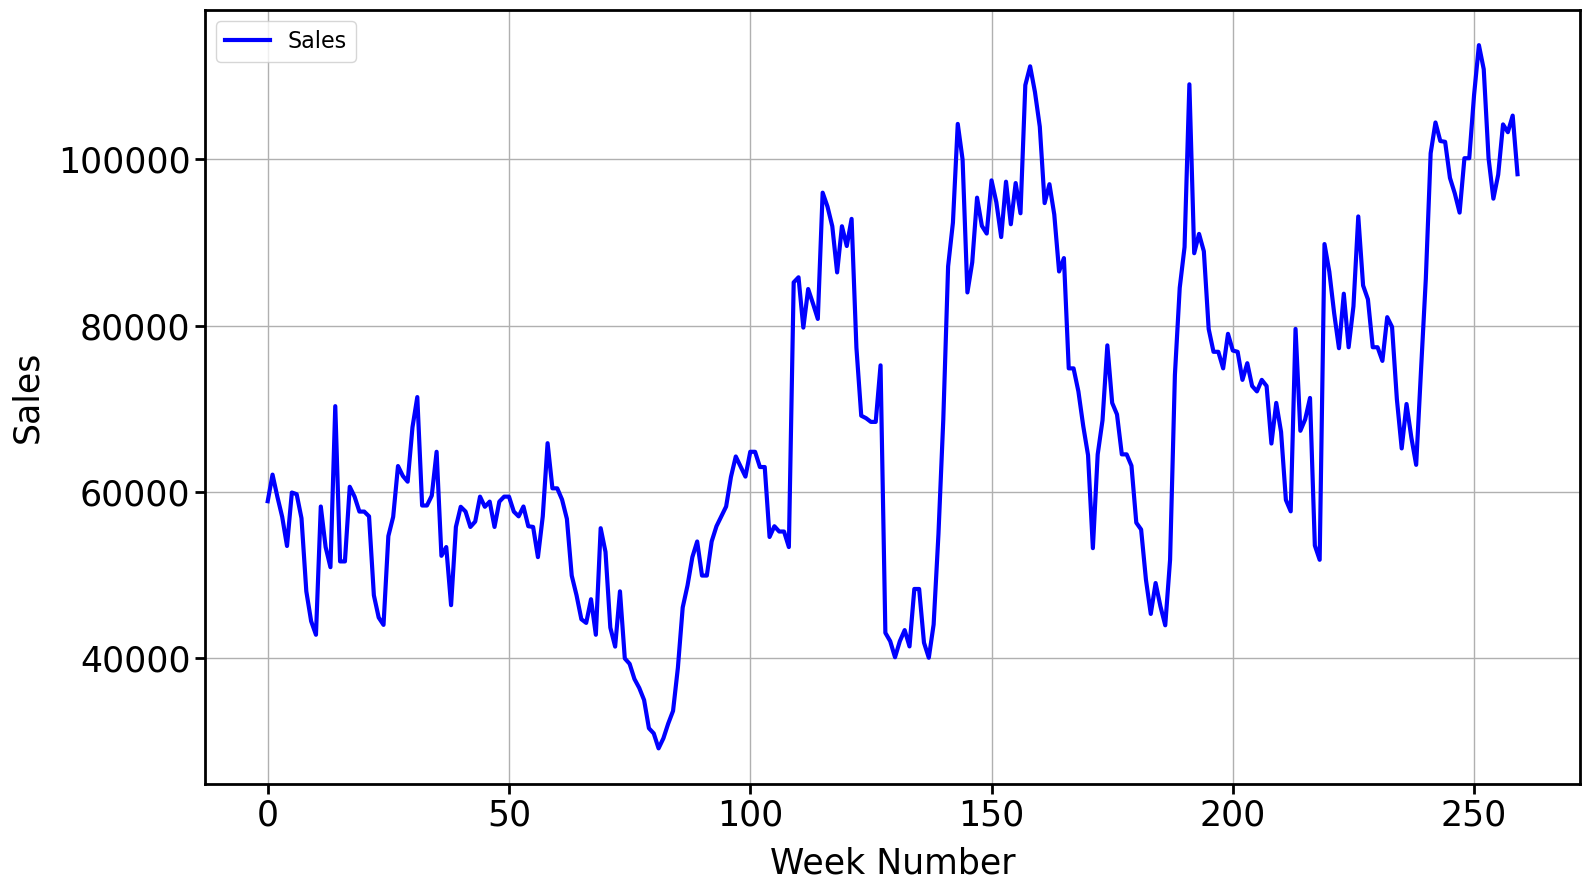

In [7]:
plt.figure(figsize=(16, 9))

plt.plot(
    df.index,
    df['sales'],
    linestyle='-',
    color='b',
    label='Sales',
    linewidth=3
)

plt.xlabel("Week Number", fontsize=25, labelpad=10)
plt.ylabel("Sales", fontsize=25, labelpad=10)

plt.yticks(fontsize=25)
plt.xticks(rotation=0, fontsize=25)

ax = plt.gca()
for spine in ['bottom', 'left', 'top', 'right']:
    ax.spines[spine].set_linewidth(2)
ax.tick_params(axis='both', which='both', width=2, length=7)

plt.grid(True, linewidth=1)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("sales_timeseries.jpg", format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
df.sales.describe()

count       260.000000
mean      68107.553558
std       19608.831323
min       29088.000000
25%       54405.000000
50%       64442.070000
75%       83872.112000
max      113762.880000
Name: sales, dtype: float64

In [9]:
df[mdsp_cols].describe()

,branded_search,nonbranded_search,facebook,print,ooh,tv,radio
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,2033.680231,402.383740,1015.262797,376.923077,188.461538,278.846154,523.076923
std,902.962242,200.049791,453.045170,487.533935,391.834536,788.512244,1033.906896
min,1375.920000,229.320000,660.231000,0.000000,0.000000,0.000000,0.000000
25%,1556.100000,238.680000,772.044000,0.000000,0.000000,0.000000,0.000000
50%,1606.800000,351.000000,827.190000,0.000000,0.000000,0.000000,0.000000
75%,1928.160000,478.378000,997.542000,500.000000,0.000000,0.000000,0.000000
max,7800.000000,1093.693000,3900.000000,1500.000000,1000.000000,2500.000000,3000.000000


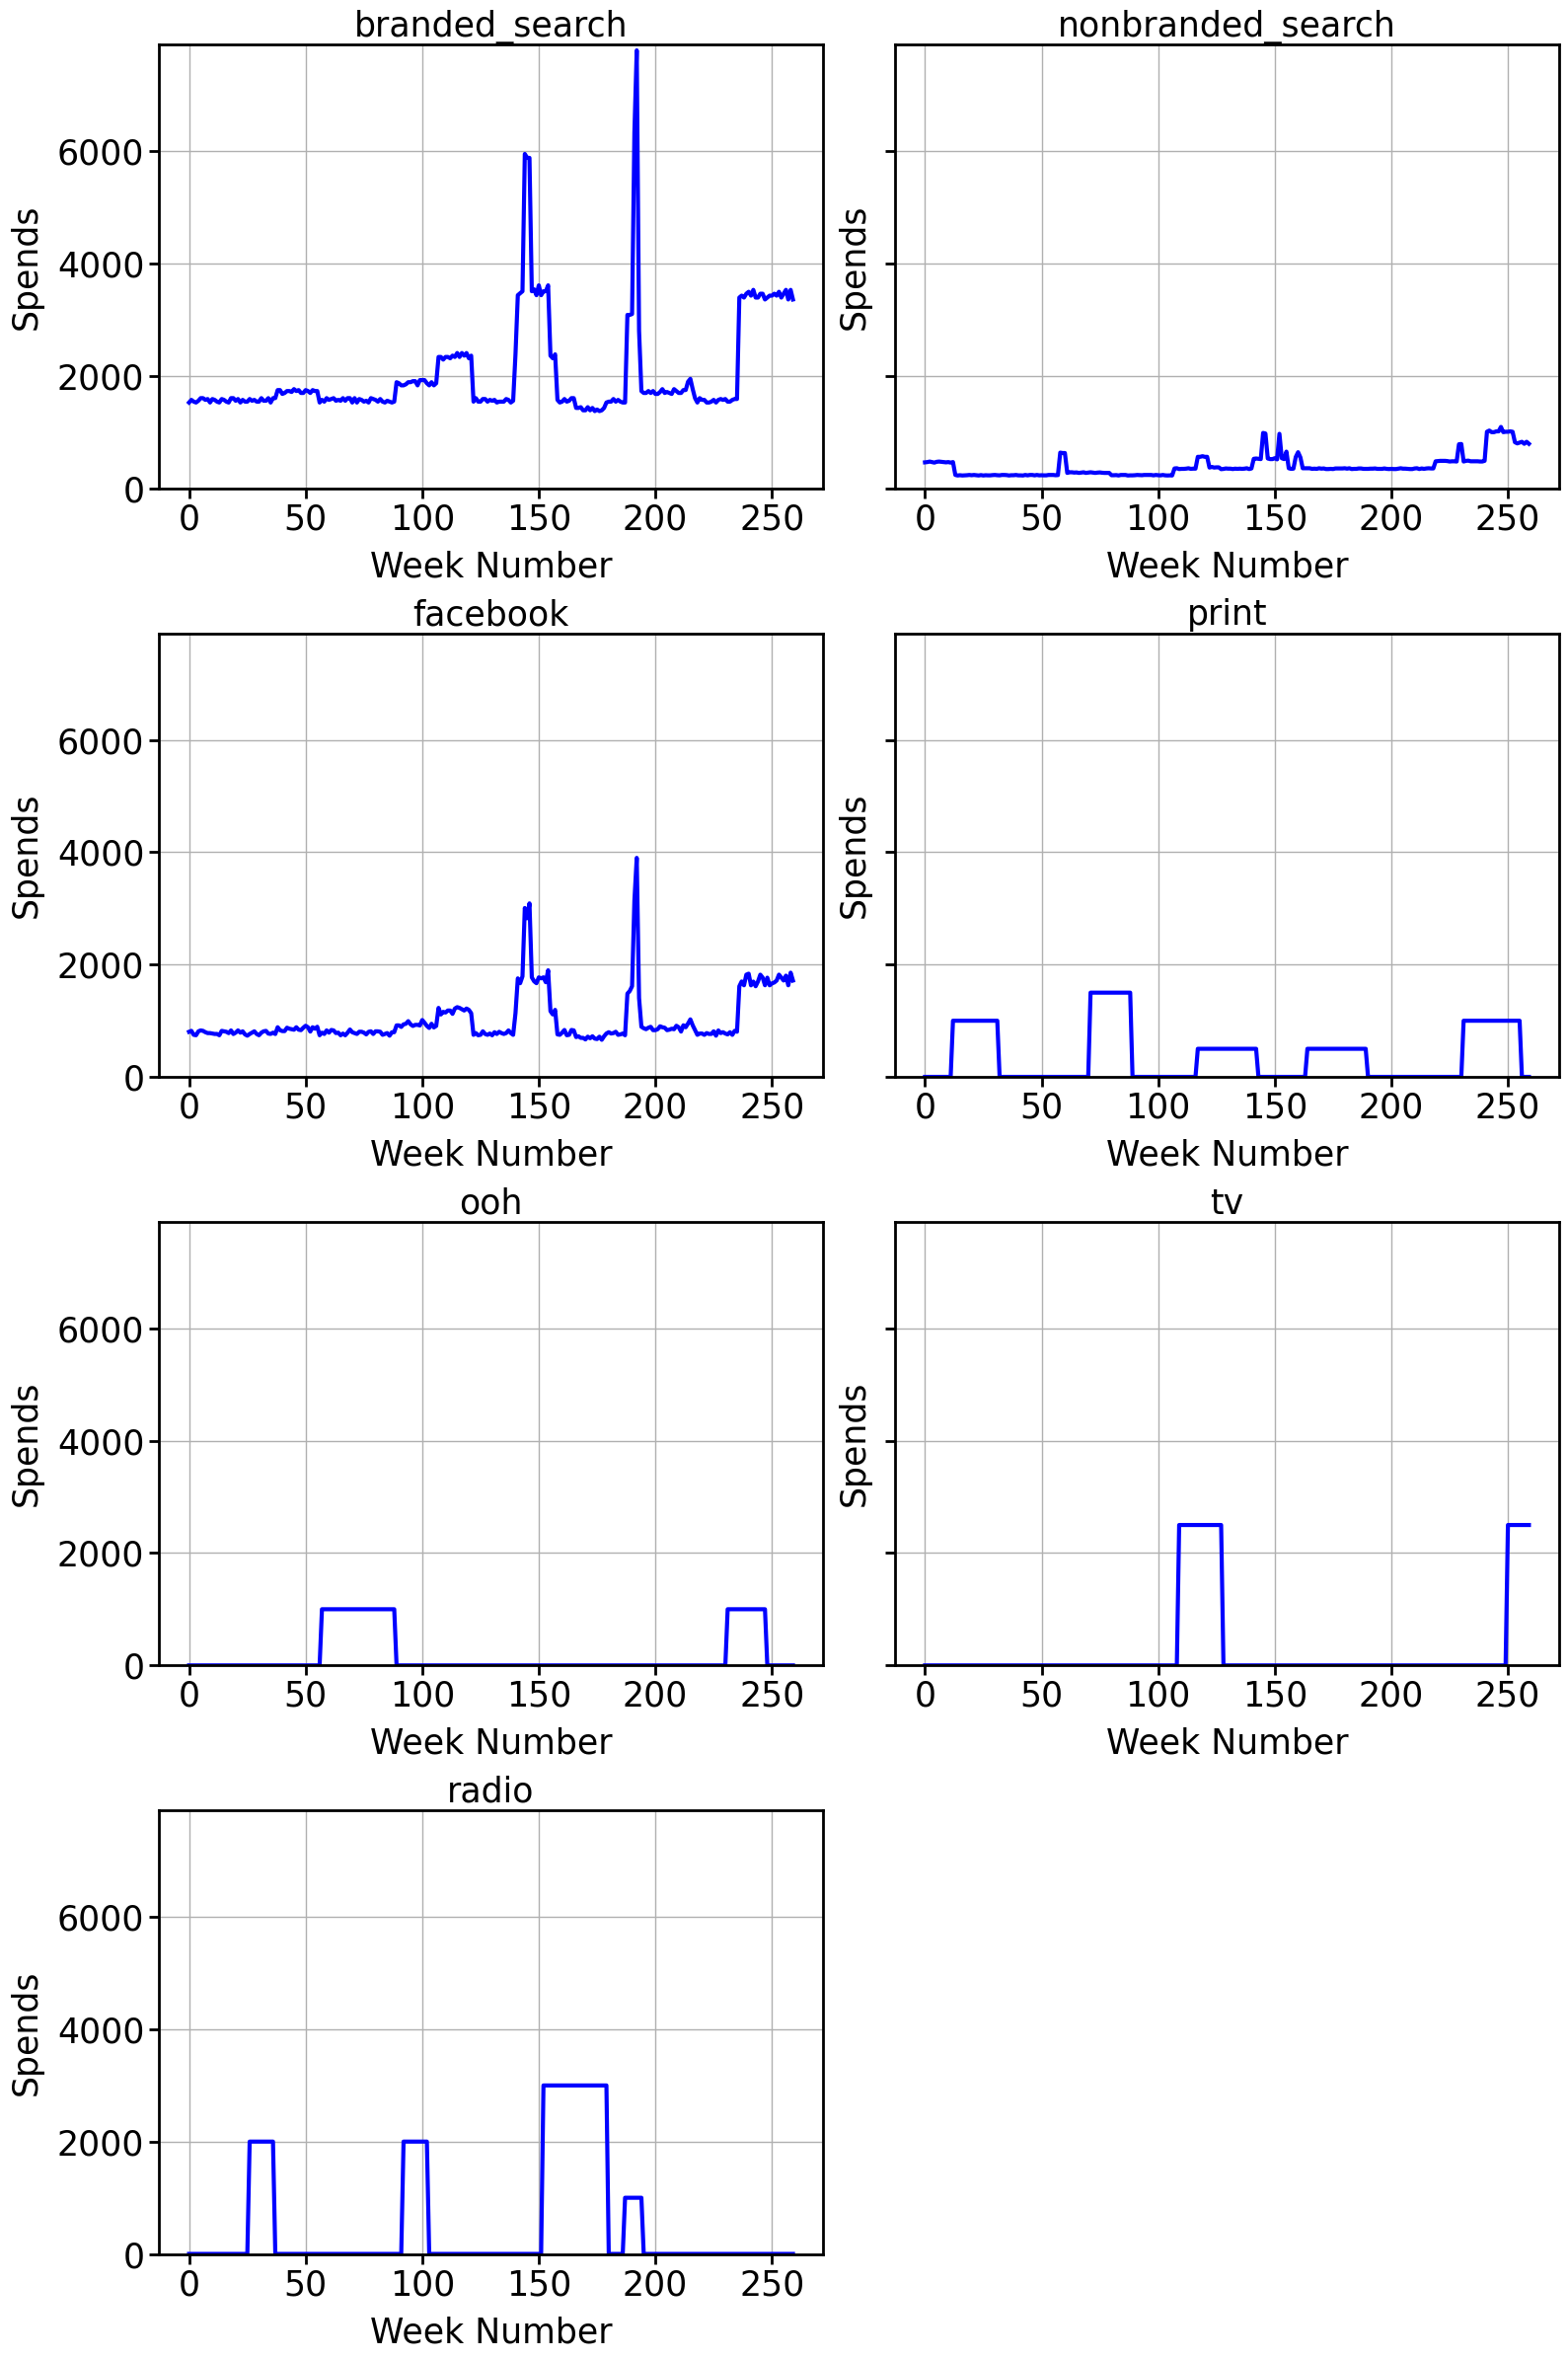

In [10]:
# Time series plots for media spends

num_cols = len(mdsp_cols)
ncols = 2 
nrows = math.ceil(num_cols / ncols)

y_min = df[mdsp_cols].min().min()
y_max = df[mdsp_cols].max().max() + 100 # to set max of y axis a bit higher than the real y

fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(16, 6 * nrows),
    sharey=True
)

axs = axs.ravel()

for i, col in enumerate(mdsp_cols):
    ax = axs[i]
    ax.plot(df.index, df[col], label=col, color='b', linewidth=3)
    ax.set_xlabel("Week Number", fontsize=25, labelpad=10)
    ax.set_ylabel("Spends", fontsize=25, labelpad=10)
    ax.set_title(f'{col}', fontsize=25)
    ax.tick_params(axis='both', which='both', width=2, length=7, labelsize=25)

    for spine in ['bottom', 'left', 'top', 'right']:
        ax.spines[spine].set_linewidth(2)

    ax.grid(True, linewidth=1)
    ax.set_ylim(y_min, y_max)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig("media_spends_timeseries.jpg", format='jpg', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
missing_cols = df[mdsp_cols].isnull().any()

missing_cols_list = missing_cols[missing_cols].index.tolist()

if missing_cols_list:
    print("Columns with NaN or null values:", missing_cols_list)
else:
    print("No NaN or null values found in the specified columns.")

No NaN or null values found in the specified columns.


In [12]:
# *Make a copy from df to feed into model
temp=df.copy()

In [13]:
# Split train and test set. 20% => test set.

SEED = 105
data_size = len(temp)

n_media_channels = len(mdsp_cols)
media_data = temp[mdsp_cols].to_numpy()
target = temp['sales'].to_numpy()
costs = temp[mdsp_cols].sum().to_numpy()

test_data_period_size = int(0.2 * len(df))     
split_point = data_size - test_data_period_size
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]

# Target
target_train = target[:split_point]

In [14]:
# scale data
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean) 
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
media_data_train = media_scaler.fit_transform(media_data_train)
target_train = target_scaler.fit_transform(target_train)

costs = cost_scaler.fit_transform(costs) # to calcuate total spemnd per media for coef_media prior

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Checking data quality

### Correlation Test

In [15]:
correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_scaler.transform(media_data),
    target_data=target_scaler.transform(target),
    cost_data=costs)

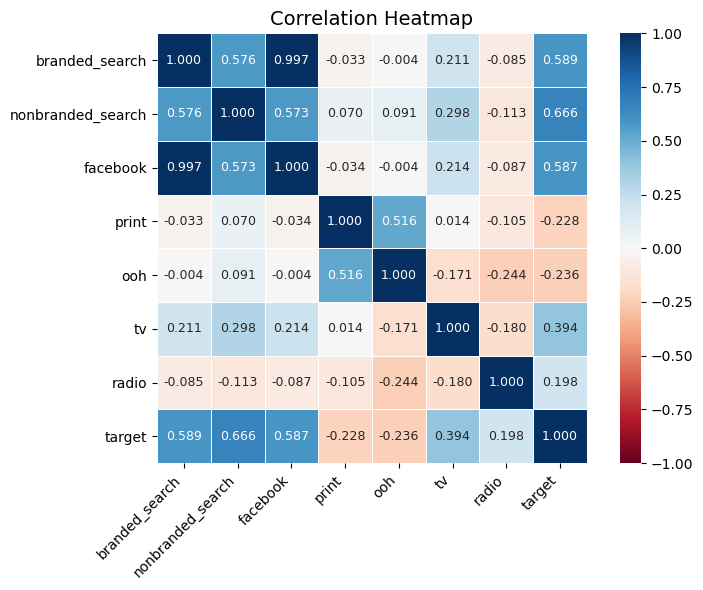

In [16]:
# Correlation heatmap
correlation_df = correlations[0].copy()
all_columns = mdsp_cols + ['target']

correlation_df.index = all_columns
correlation_df.columns = all_columns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df,
            annot=True,
            fmt=".3f",
            cmap="RdBu",
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar=True,
            annot_kws={"size": 9})

plt.title("Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()
plt.savefig("correlation_heatmap.jpg", dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

### Variance Test

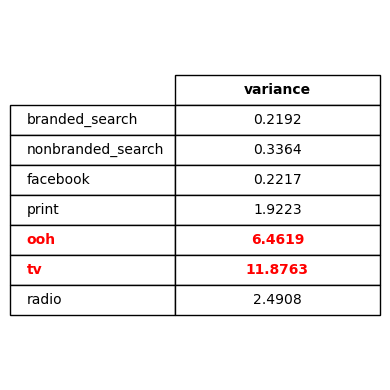

In [17]:

v_arr = variances["geo_0"].to_numpy().ravel() 

# Build DataFrame indexed by channel names
variances_df = pd.DataFrame(
    {"variance": v_arr},
    index=mdsp_cols
)

# Set thresholds & color coding
low_threshold = 1e-3
high_threshold = 3.0

rounded_vals = variances_df.round(4).astype(str)

colors = []
for val in variances_df["variance"]:
    if val < low_threshold or val > high_threshold:
        colors.append("red")
    else:
        colors.append("black")

# Plot the table
fig, ax = plt.subplots(figsize=(4, 4))
fig.patch.set_facecolor("white")
ax.axis("off")

table = ax.table(
    cellText=rounded_vals.values,
    rowLabels=rounded_vals.index,
    colLabels=rounded_vals.columns,
    loc="center",
    cellLoc="center"
)

table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

for (row, col), cell in table.get_celld().items():
    if row == 0:  # header row
        cell.set_text_props(weight="bold")
    else:
        color = colors[row - 1]          
        cell.get_text().set_color(color)
        if color == "red":
            cell.get_text().set_weight("bold")

plt.tight_layout()
plt.show()

fig.savefig("variance_table.jpeg", dpi=300, bbox_inches="tight", facecolor="white")
plt.close(fig)

### Spend Fraction Test

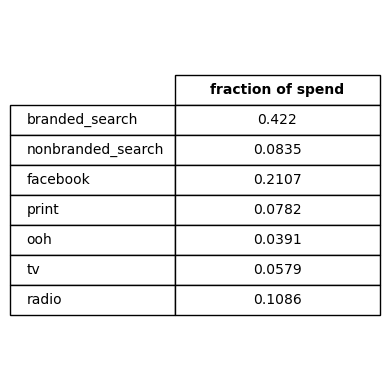

In [18]:
sf_arr = spend_fractions.iloc[:, 0].to_numpy().ravel()   

spend_df = pd.DataFrame(
    {"fraction of spend": sf_arr},
    index=mdsp_cols
)

# Threshold rule  
low_spend_threshold = 0.025 

rounded_vals = spend_df.round(4).astype(str)

colors = []
weights = []
for val in spend_df["fraction of spend"]:
    if val < low_spend_threshold:
        weights.append("bold")
        colors.append("red")
    else:
        weights.append("normal")
        colors.append("black")

#  Plot the table 
fig, ax = plt.subplots(figsize=(4, 4))
fig.patch.set_facecolor("white")
ax.axis("off")

table = ax.table(
    cellText=rounded_vals.values,
    rowLabels=rounded_vals.index,
    colLabels=rounded_vals.columns,
    loc="center",
    cellLoc="center",
)

table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

# Apply text color and weight
for (row, col), cell in table.get_celld().items():
    if row == 0:  # header row
        cell.set_text_props(weight="bold")
    else:
        color = colors[row - 1]       
        weight = weights[row - 1]
        cell.get_text().set_color(color)
        cell.get_text().set_weight(weight)

plt.tight_layout()
plt.show()

fig.savefig("spend_fraction_table.jpeg",
            dpi=300, bbox_inches="tight", facecolor="white")
plt.close(fig)

In [19]:
# Since branded_search and facebook corr score is high, branded_search is dropped
mdsp_cols.remove("branded_search")
print(mdsp_cols)

['nonbranded_search', 'facebook', 'print', 'ooh', 'tv', 'radio']


In [20]:
# Repeating the the split and scaling phase again, now that branded_search is dropped.
SEED = 105
data_size = len(temp)

n_media_channels = len(mdsp_cols)
# n_extra_features = len(control_vars)
media_data = temp[mdsp_cols].to_numpy()
# extra_features = temp[control_vars].to_numpy()
target = temp['sales'].to_numpy()
costs = temp[mdsp_cols].sum().to_numpy()

test_data_period_size = int(0.2 * len(df))     
split_point = data_size - test_data_period_size
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]

# Target
target_train = target[:split_point]

In [21]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean) 
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
media_data_train = media_scaler.fit_transform(media_data_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

# Modeling 

In [22]:
# Sampling configuration
number_warmup = 1000    # burn-in iterations (not saved)
number_samples = 2000   # kept posterior samples per chain
number_chains = 2       # parallel chains for convergence diagnostics

# Instantiate the MMM with adstock (geometric decay) on media
mmm = lightweight_mmm.LightweightMMM(model_name="adstock")
mmm.fit( 
        weekday_seasonality=False,   # Turn off weekday dummies, but keep yearly seasonality (weekly frequency) since the data is on weekly basis not daily
        seasonality_frequency=52,
        custom_priors={
            # Intercept is constrained to be non-negative with a fairly wide HalfNormal
             "intercept": numpyro.distributions.HalfNormal(scale=10),
             # Lag weights (adstock) get channel-specific Beta priors
             "lag_weight": numpyro.distributions.Beta(concentration1=jnp.array([2,    2,    4.5,  4.5,  2,    4.5]), 
                                                      concentration0=jnp.array([11.3, 11.3, 13.5, 13.5, 1.63, 13.5]))},
    
        # Training data
        media=media_data_train, 
        extra_features=None,    # no extra regressors in this data
        media_prior=costs,      # used to set prior scales for media coefficients
        target=target_train,   
    
        # MCMC settings
        number_warmup=number_warmup, 
        number_samples=number_samples, 
        seed=SEED, 
        number_chains = number_chains,
    
    
        media_names = mdsp_cols   # list of channel names in media_data_train order
)

/opt/conda/envs/lwmm/lib/python3.9/site-packages/lightweight_mmm/lightweight_mmm.py:357: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 3000/3000 [03:55<00:00, 12.75it/s, 1023 steps of size 4.26e-03. acc. prob=0.88]


In [23]:
# Inspect posterior summaries and MCMC diagnostics (means, intervals, R-hat, n_eff, divergences)
# mean – posterior mean of that parameter
# std – posterior standard deviation
# median – posterior median
# 5.0%, 95.0% – central 90% credible interval (5th and 95th percentiles)
# r_hat – convergence diagnostic (should be very close to 1.00)
# At the bottom, Number of diverge
mmm.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
         coef_media[0]      0.14      0.06      0.13      0.05      0.24   2245.63      1.00
         coef_media[1]      0.35      0.12      0.32      0.18      0.53    610.13      1.00
         coef_media[2]      0.01      0.01      0.01      0.00      0.03   2632.17      1.00
         coef_media[3]      0.00      0.00      0.00      0.00      0.00   4937.96      1.00
         coef_media[4]      0.04      0.01      0.04      0.02      0.05   1915.05      1.00
         coef_media[5]      0.07      0.01      0.07      0.05      0.09   2239.67      1.00
         coef_trend[0]      0.00      0.00      0.00      0.00      0.00    610.01      1.01
            expo_trend      1.23      0.22      1.29      0.91      1.50    380.03      1.02
           exponent[0]      0.86      0.12      0.89      0.68      1.00   3753.08      1.00
           exponent[1]      0.78      0.14      0.80      0.58      1

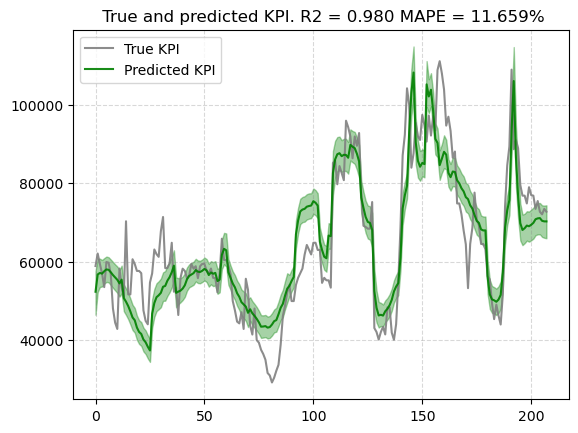

In [24]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

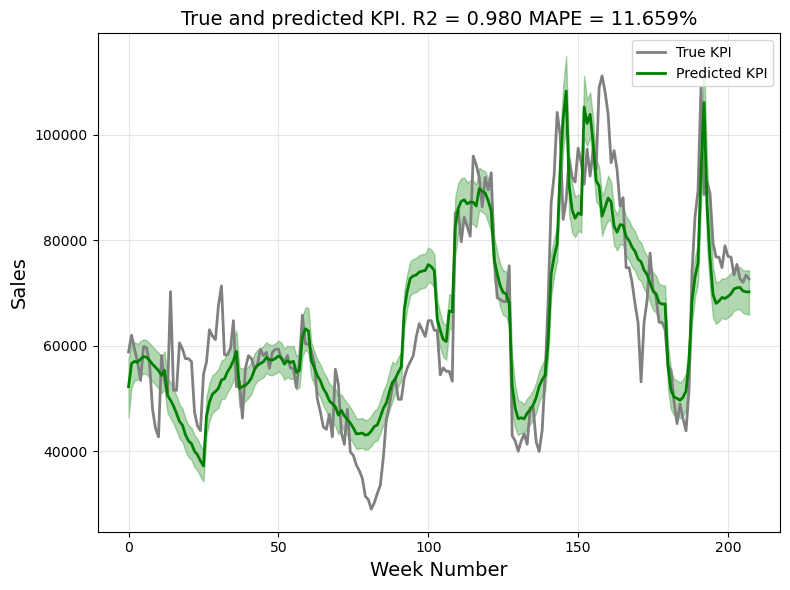

In [25]:
# Plot model fit for training set
def plot_in_sample_model_fit(
    mu_unscaled,
    target_unscaled,
    r2_str,
    mape_str,
    interval_mid_range: float = 0.9,
    figsize=(8, 6),
    x_values=None,
):

    preds = np.asarray(mu_unscaled)
    y_true = np.asarray(target_unscaled).ravel()

    n_draws, n_time = preds.shape

    # x-axis
    if x_values is None:
        x = np.arange(n_time)
    else:
        x = np.asarray(x_values)
        if len(x) != n_time:
            raise ValueError(
                f"x_values length ({len(x)}) != n_time ({n_time})"
            )

    # credible interval + mean over draws
    lower_q = (1 - interval_mid_range) / 2
    upper_q = 1 - lower_q

    y_pred_mean = preds.mean(axis=0)
    y_pred_lower = np.quantile(preds, lower_q, axis=0)
    y_pred_upper = np.quantile(preds, upper_q, axis=0)

    # plotting
    fig, ax = plt.subplots(figsize=figsize)

    # shaded credible interval
    ax.fill_between(
        x,
        y_pred_lower,
        y_pred_upper,
        color="green",
        alpha=0.3,
        zorder=1,
    )

    # True line
    ax.plot(
        x,
        y_true,
        color="grey",
        linewidth=2,
        label="True KPI",
        zorder=2,
    )

    # Predicted mean from mu
    ax.plot(
        x,
        y_pred_mean,
        color="green",
        linewidth=2,
        label="Predicted KPI",
        zorder=3,
    )

    ax.set_title(
        f"True and predicted KPI. R2 = {r2_str} MAPE = {mape_str}%",
        fontsize=14,
    )
    ax.set_xlabel("Week Number", fontsize=14)
    ax.set_ylabel("Sales", fontsize=14)

    ax.legend(loc="upper right", fontsize=10, frameon=True)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig, ax


# Get R2 & MAPE for train set
fig_tmp = plot.plot_model_fit(mmm, target_scaler=target_scaler)
ax_tmp = fig_tmp.axes[0]
title_tmp = ax_tmp.get_title()
plt.close(fig_tmp)
m = re.search(r"R2\s*=\s*([0-9.]+)\s*MAPE\s*=\s*([0-9.]+)%", title_tmp)
if m:
    r2_str, mape_str = m.group(1), m.group(2)
else:
    r2_str, mape_str = "nan", "nan"

    
# Use mu from the trace and unscale it
mu_scaled = np.asarray(mmm.trace["mu"])  
if mu_scaled.ndim == 3:                   
    mu_scaled = mu_scaled[:, :, 0]

# unscale mu to Sales units
mu_unscaled = target_scaler.inverse_transform(
    mu_scaled.reshape(-1, 1)
).reshape(mu_scaled.shape)

# target on original scale for TRAIN period
target_train_unscaled = np.asarray(target[:mu_unscaled.shape[1]])

# x-axis as week index
x_values_train = np.arange(mu_unscaled.shape[1])

fig_train, ax_train = plot_in_sample_model_fit(
    mu_unscaled=mu_unscaled,
    target_unscaled=target_train_unscaled,
    r2_str=r2_str,
    mape_str=mape_str,
    interval_mid_range=0.9,
    figsize=(8, 6),
    x_values=x_values_train,
)

plt.show()
fig_train.savefig(
    "model_fit.jpeg",
    format="jpeg",
    dpi=300,
    bbox_inches="tight",
)


In [26]:
# Compute posterior media contributions over time and ROI per channel
media_contribution, roi_hat = mmm.get_posterior_metrics(
    target_scaler=target_scaler,
    cost_scaler=cost_scaler,
)

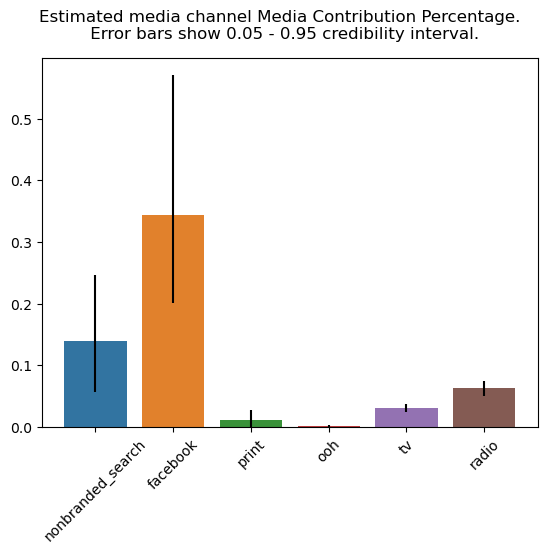

In [27]:
# Visualize each channel’s share of total modeled contribution as a bar chart
plot.plot_bars_media_metrics(
    metric=media_contribution,
    channel_names=mdsp_cols,
    metric_name="Media Contribution Percentage",
)

In [28]:
# Build a DataFrame with baseline prediction + weekly media contributions per channel (on original scale)
cont = plot.create_media_baseline_contribution_df(
    media_mix_model=mmm,
    target_scaler=target_scaler,
    channel_names=mdsp_cols,
)

# Quick summary stats for all columns in the contribution table
cont.describe()


,nonbranded_search_percentage,facebook_percentage,print_percentage,ooh_percentage,tv_percentage,radio_percentage,baseline_percentage,avg_prediction,nonbranded_search contribution,facebook contribution,print contribution,ooh contribution,tv contribution,radio contribution,baseline contribution,period
count,208.000000,208.000000,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,208.000000,208.000000,208.000000,208.000000,208.000000,2.080000e+02,208.000000,208.000000,208.000000,208.000000
mean,0.142270,0.350362,1.490858e-02,1.647313e-03,2.475507e-02,5.572024e-02,0.410337,64110.644531,8947.338604,22017.103915,765.843498,8.084922e+01,1981.333011,4039.882491,26278.291016,104.500000
std,0.032163,0.066911,2.109109e-02,3.855163e-03,7.565840e-02,9.022330e-02,0.086217,16009.370117,2600.133878,6340.426716,976.270166,1.874128e+02,6102.634269,6618.134529,7877.226074,60.188592
min,0.086321,0.220698,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.206410,37266.074219,6457.052734,15168.602539,0.000000,0.000000e+00,0.000000,0.000000,10056.501953,1.000000
25%,0.118725,0.297215,8.636968e-07,0.000000e+00,0.000000e+00,5.104368e-11,0.352408,51557.394531,6637.518433,19005.240234,0.060621,0.000000e+00,0.000000,0.000003,20348.476074,52.750000
50%,0.135960,0.354574,4.191586e-04,4.626237e-19,0.000000e+00,4.825547e-06,0.416032,57776.826172,9079.711426,19695.795898,31.655586,4.059716e-14,0.000000,0.307250,27176.441406,104.500000
75%,0.163227,0.391565,2.243186e-02,4.112363e-09,1.740681e-08,9.015746e-02,0.467764,74329.666016,9286.624268,21564.600586,1170.121674,3.130557e-04,0.001524,6767.294067,32453.833008,156.250000
max,0.234880,0.558310,7.036424e-02,1.214318e-02,3.164234e-01,2.645417e-01,0.581511,108307.554688,21137.851562,59259.445312,3033.074951,5.233646e+02,21541.949219,17974.892578,40980.691406,208.000000


In [29]:
cont

,nonbranded_search_percentage,facebook_percentage,print_percentage,ooh_percentage,tv_percentage,radio_percentage,baseline_percentage,avg_prediction,nonbranded_search contribution,facebook contribution,print contribution,ooh contribution,tv contribution,radio contribution,baseline contribution,period
0,0.181301,0.290132,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.528567,52281.695312,9478.724609,15168.602539,0.000000,0.000000e+00,0.000000e+00,0.000000,27634.367188,1
1,0.194766,0.321275,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.483959,56692.933594,11041.874023,18214.027344,0.000000,0.000000e+00,0.000000e+00,0.000000,27437.033203,2
2,0.203064,0.319890,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.477046,57084.800781,11591.847656,18260.857422,0.000000,0.000000e+00,0.000000e+00,0.000000,27232.093750,3
3,0.203713,0.321376,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.474910,56907.894531,11592.890625,18288.857422,0.000000,0.000000e+00,0.000000e+00,0.000000,27026.148438,4
4,0.199311,0.334491,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.466199,57518.371094,11464.039062,19239.349609,0.000000,0.000000e+00,0.000000e+00,0.000000,26814.984375,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.128620,0.295010,1.615715e-06,7.323319e-27,3.492890e-14,0.000051,0.576318,71029.148438,9135.757812,20954.279297,0.114763,5.201691e-22,2.480970e-09,3.609094,40935.390625,204
204,0.130486,0.293129,1.169808e-06,4.833391e-27,2.566470e-14,0.000027,0.576357,71102.929688,9277.922852,20842.339844,0.083177,3.436683e-22,1.824835e-09,1.893242,40980.691406,205
205,0.130463,0.288011,8.737871e-07,3.225413e-27,1.906557e-14,0.000014,0.581511,70411.492188,9186.108398,20279.265625,0.061525,2.271062e-22,1.342435e-09,1.016091,40945.039062,206
206,0.130523,0.288069,6.587895e-07,2.136395e-27,1.405715e-14,0.000008,0.581399,70263.671875,9171.059570,20240.773438,0.046289,1.501109e-22,9.877069e-10,0.556604,40851.234375,207


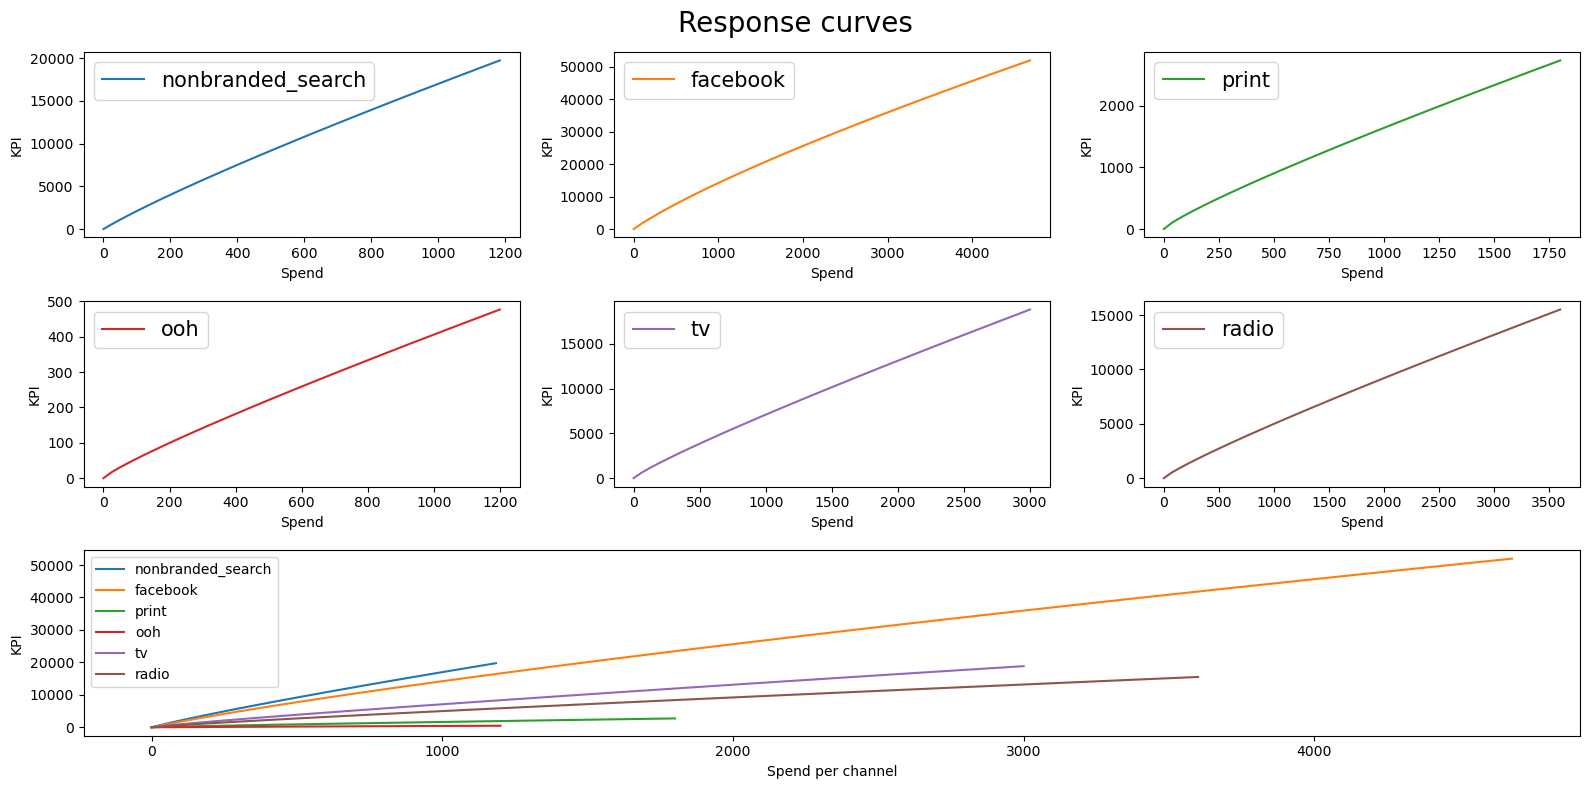

In [30]:
# Plot marginal response curves for each media channel (spend vs. predicted sales),
plot.plot_response_curves(
    media_mix_model=mmm,
    target_scaler=target_scaler,
    media_scaler=media_scaler,
    seed=SEED,
    n_columns=3,
    figure_size=(16, 8),
    legend_fontsize=15,
    marker_size=15,
)

In [31]:
# prediction for test set
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test), seed=SEED)
new_predictions.shape

(4000, 52)

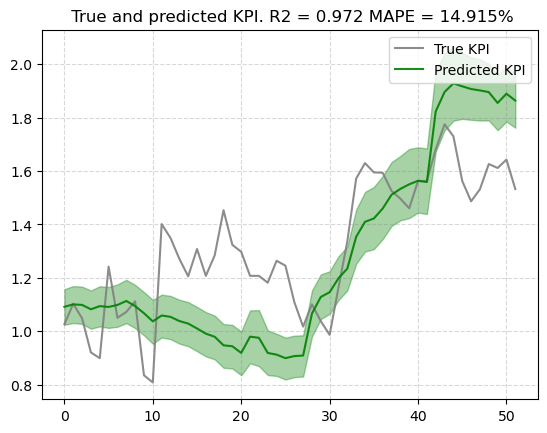

In [32]:
# Test-set model fit
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

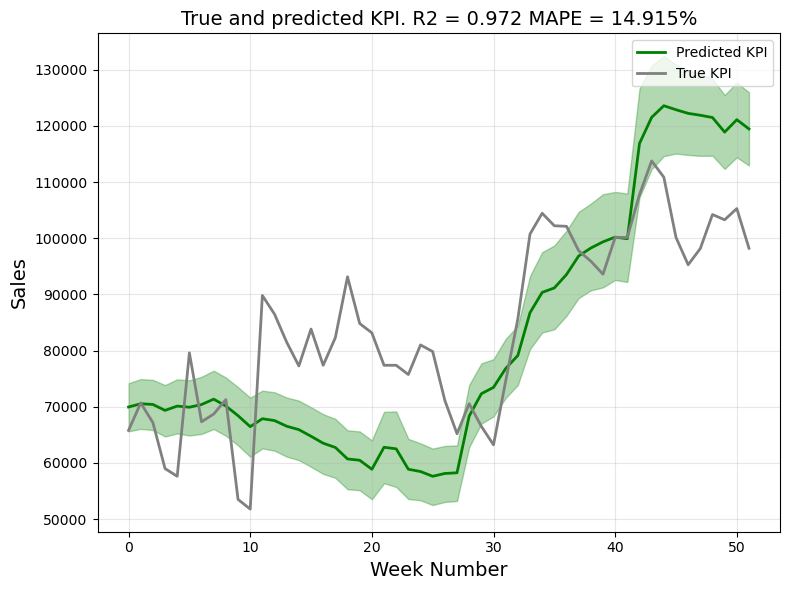

In [33]:
def plot_out_of_sample_model_fit(
    predictions_unscaled,
    target_unscaled,
    r2_str,
    mape_str,
    interval_mid_range: float = 0.9,
    figsize=(8, 6),
    x_values=None,
):

    preds = np.asarray(predictions_unscaled)
    y_true = np.asarray(target_unscaled).ravel()

    n_draws, n_time = preds.shape

    # x-axis
    if x_values is None:
        x = np.arange(n_time)
    else:
        x = np.asarray(x_values)
        if len(x) != n_time:
            raise ValueError(
                f"x_values length ({len(x)}) != n_time ({n_time})"
            )

    # credible interval + mean
    lower_q = (1 - interval_mid_range) / 2
    upper_q = 1 - lower_q

    y_pred_mean = preds.mean(axis=0)
    y_pred_lower = np.quantile(preds, lower_q, axis=0)
    y_pred_upper = np.quantile(preds, upper_q, axis=0)

    # plotting
    fig, ax = plt.subplots(figsize=figsize)

    ax.fill_between(
        x,
        y_pred_lower,
        y_pred_upper,
        color="green",
        alpha=0.3,
    )

    ax.plot(
        x,
        y_pred_mean,
        color="green",
        linewidth=2,
        label="Predicted KPI",
    )

    ax.plot(
        x,
        y_true,
        color="grey",
        linewidth=2,
        label="True KPI",
    )

    # use EXACT R2 / MAPE from LWMMM
    ax.set_title(
        f"True and predicted KPI. R2 = {r2_str} MAPE = {mape_str}%",
        fontsize=14,
    )

    ax.set_xlabel("Week Number", fontsize=14)
    ax.set_ylabel("Sales", fontsize=14)

    ax.legend(loc="upper right", fontsize=10, frameon=True)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig, ax

# predictions on test-set
new_predictions = np.asarray(new_predictions)


# Calculate R2 & MAPE on the scaled data
fig_tmp = plot.plot_out_of_sample_model_fit(
    out_of_sample_predictions=new_predictions,
    out_of_sample_target=target_scaler.transform(target[split_point:]),
)
ax_tmp = fig_tmp.axes[0]
title_tmp = ax_tmp.get_title()
plt.close(fig_tmp) 

m = re.search(r"R2\s*=\s*([0-9.]+)\s*MAPE\s*=\s*([0-9.]+)%", title_tmp)
if m:
    r2_str, mape_str = m.group(1), m.group(2)
else:
    r2_str, mape_str = "nan", "nan"

# Unscale predictions & target
new_predictions_unscaled = target_scaler.inverse_transform(
    new_predictions.reshape(-1, 1)
).reshape(new_predictions.shape)

target_test_unscaled = np.asarray(target[split_point:])

# simple week index as x-axis
x_values = np.arange(new_predictions_unscaled.shape[1])

fig, ax = plot_out_of_sample_model_fit(
    predictions_unscaled=new_predictions_unscaled,
    target_unscaled=target_test_unscaled,
    r2_str=r2_str,
    mape_str=mape_str,
    interval_mid_range=0.9,
    figsize=(8, 6),
    x_values=x_values,
)

plt.show()
fig.savefig(
    "Model_Fit_Testset.jpeg",
    format="jpeg",
    dpi=300,
    bbox_inches="tight",
)

In [34]:
# Consistent color palette for all mdeia related plots 
media_colors = {
    'nonbranded_search': '#1f77b4',
    'facebook':          '#ff7f0e',
    'print':             '#2ca02c',
    'ooh':               '#d62728',
    'tv':                '#9467bd',
    'radio':             '#8c564b',
}

In [35]:
# Lightweight 1D kernel density estimator used to draw smooth prior/posterior curves
def _gaussian_kde_1d(samples, grid, bw=None):
    """Very small helper for 1D KDE using only numpy."""
    samples = np.asarray(samples, dtype=float).ravel()
    n = samples.size
    if n < 2:
        return np.zeros_like(grid)

    if bw is None:
        std = samples.std(ddof=1)
        if not np.isfinite(std) or std == 0:
            bw = 0.05  # fallback
        else:
            bw = 1.06 * std * n ** (-1.0 / 5.0)  # Silverman's rule

    bw2 = bw ** 2
    diffs = grid[None, :] - samples[:, None]
    kernel_vals = np.exp(-0.5 * (diffs ** 2) / bw2)
    density = kernel_vals.sum(axis=0) / (n * np.sqrt(2 * np.pi) * bw)
    return density

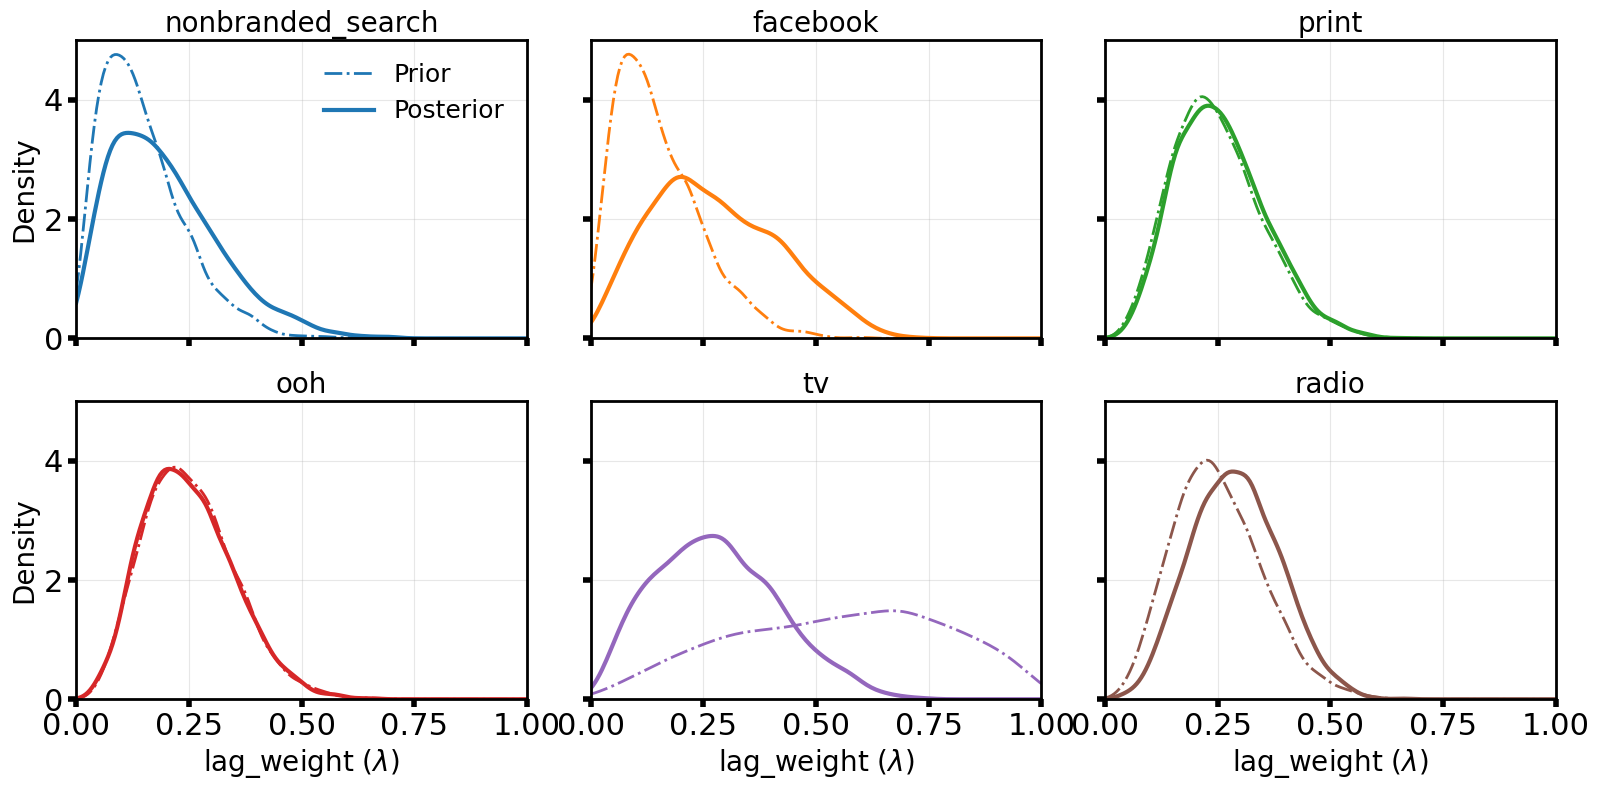

In [36]:
def plot_lag_weight_prior_posterior(
    mmm,
    channel_names,
    n_prior_samples=4000,
    n_grid=200,
    seed=0,
):
    """
    Plot prior & posterior densities for lag_weight per channel.

    Parameters
    ----------
    mmm : lightweight_mmm.LightweightMMM
        Fitted model containing trace["lag_weight"] and custom_priors["lag_weight"].
    channel_names : list[str]
        Names of media channels in the same order as in the model.
    n_prior_samples : int
        Number of samples to draw from the prior.
    n_grid : int
        Number of grid points in [0,1] for the density curves.
    seed : int
        Random seed for sampling from the prior.
    """

    # Posterior from trace 
    lag_post = np.asarray(mmm.trace["lag_weight"])
    if lag_post.ndim == 3:
        lag_post = lag_post[:, :, 0]

    n_post_samples, n_channels_post = lag_post.shape
    n_channels = len(channel_names)

    lag_prior_dist = mmm.custom_priors["lag_weight"]
    key = random.PRNGKey(seed)

    prior_samples_all = np.asarray(
        lag_prior_dist.sample(key, sample_shape=(n_prior_samples,))
    )

    # grid on [0,1] since lag_weight is a weight
    x = np.linspace(0.0, 1.0, n_grid)

    # ----- 3. Subplots layout -----
    n_cols = 3
    n_rows = int(np.ceil(n_channels / n_cols))
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(16, 4 * n_rows),   
        sharex=True,
        sharey=True,
    )
    axes = np.array(axes).reshape(-1)

    # One panel per channel
    for i, ch_name in enumerate(channel_names):
        ax = axes[i]
        color = media_colors.get(ch_name, "#333333")

        prior_samples = prior_samples_all[:, i]
        post_samples  = lag_post[:, i]

        prior_density = _gaussian_kde_1d(prior_samples, x)
        post_density  = _gaussian_kde_1d(post_samples,  x)

        # Prior = dashed, Posterior = solid
        ax.plot(
            x,
            prior_density,
            linestyle="-.",
            color=color,
            linewidth=2.0,
            label="Prior",
        )
        ax.plot(
            x,
            post_density,
            linestyle="-",
            color=color,
            linewidth=3.0,
            label="Posterior",
        )

        ax.set_title(ch_name, fontsize=20)
        ax.set_xlim(0, 1)
        ax.set_ylim(bottom=0)

        if i % n_cols == 0:
            ax.set_ylabel("Density", fontsize=20)

        if i >= (n_rows - 1) * n_cols:
            ax.set_xlabel(r"lag_weight ($\lambda$)", fontsize=20)

        ax.grid(True, alpha=0.3)

    # styling the plot
    for ax in axes:
        if not ax.has_data():
            continue
        ax.tick_params(
            axis="both",
            which="both",
            width=4,
            length=6,
            labelsize=22,
        )
        for spine in ["bottom", "left", "top", "right"]:
            ax.spines[spine].set_linewidth(2)

    # Put legend on the first axis that has data
    for ax in axes:
        if ax.has_data():
            ax.legend(loc="upper right", frameon=False, fontsize=18)
            break

    fig.tight_layout()
    return fig



fig = plot_lag_weight_prior_posterior(
    mmm,
    channel_names=mdsp_cols,
    n_prior_samples=4000,
    seed=123,
)

plt.show()
fig.savefig(
    "lambda_prior_poterior.jpeg",
    format='jpeg',
    dpi=300,
    bbox_inches='tight'
)


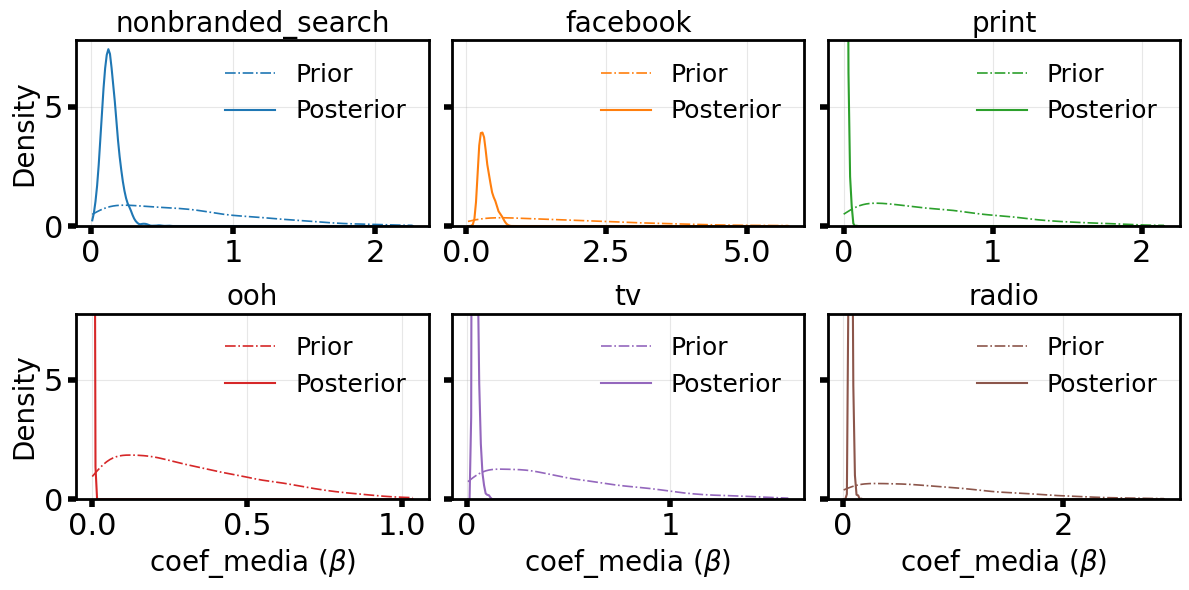

In [37]:
def plot_coef_media_prior_posterior(
    mmm,
    channel_names,
    n_prior_samples=4000,
    n_grid=200,
    seed=0,
):
    """
    Plot prior & posterior densities for coef_media per channel
    (the default HalfNormal prior was used)
    """

    # Posterior from trace
    coef_post = np.asarray(mmm.trace["coef_media"])
    if coef_post.ndim == 3:
        coef_post = coef_post[:, :, 0]

    n_post_samples, n_channels_post = coef_post.shape
    n_channels = len(channel_names)

    # Prior: HalfNormal(scale = media_prior)
    media_prior = np.asarray(mmm._media_prior)

    # Shape handling
    if media_prior.ndim == 2:
        media_prior = media_prior[:, 0] 

    key = random.PRNGKey(seed)
    coef_prior_dist = dist.HalfNormal(scale=jnp.array(media_prior))
    prior_samples_all = np.asarray(
        coef_prior_dist.sample(key, sample_shape=(n_prior_samples,))
    )

    # Plot per channel
    n_cols = 3
    n_rows = int(np.ceil(n_channels / n_cols))
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 3 * n_rows),
        sharex=False,
        sharey=True,
    )
    axes = np.array(axes).reshape(-1)

    for i, ch_name in enumerate(channel_names):
        ax = axes[i]
        # use specified color
        color = media_colors.get(ch_name, "#333333")

        prior_samples = prior_samples_all[:, i]
        post_samples = coef_post[:, i]

        # Choose a sensible x-range from combined prior+posterior
        combined = np.concatenate([prior_samples, post_samples])
        x_min = np.quantile(combined, 0.005)
        x_max = np.quantile(combined, 0.995)
        if x_max <= x_min:
            x_min -= 1e-6
            x_max += 1e-6

        x = np.linspace(x_min, x_max, n_grid)

        # KDEs
        prior_density = _gaussian_kde_1d(prior_samples, x)
        post_density = _gaussian_kde_1d(post_samples, x)

        # Prior = dashed, Posterior = solid
        ax.plot(
            x,
            prior_density,
            linestyle="-.",
            color=color,
            linewidth=1.2,
            label="Prior",
        )
        ax.plot(
            x,
            post_density,
            linestyle="-",
            color=color,
            linewidth=1.5,
            label="Posterior",
        )

        ax.set_title(ch_name, fontsize=20)
        ax.set_ylim(bottom=0)

        if i % n_cols == 0:
            ax.set_ylabel("Density", fontsize=20)
        if i >= (n_rows - 1) * n_cols:
            ax.set_xlabel(r"coef_media ($\beta$)", fontsize=20)

        ax.grid(True, alpha=0.3)

        
    for ax in axes:
        if not ax.has_data():
            continue
        ax.tick_params(axis="both", which="both",
                       width=4, length=6, labelsize=22)
        for spine in ["bottom", "left", "top", "right"]:
            ax.spines[spine].set_linewidth(2)

    axes[0].legend(loc="upper right", frameon=False, fontsize=18)
    axes[1].legend(loc="upper right", frameon=False, fontsize=18)
    axes[2].legend(loc="upper right", frameon=False, fontsize=18)
    axes[3].legend(loc="upper right", frameon=False, fontsize=18)
    axes[4].legend(loc="upper right", frameon=False, fontsize=18)
    axes[5].legend(loc="upper right", frameon=False, fontsize=18)
    fig.tight_layout()
    return fig



fig = plot_coef_media_prior_posterior(
    mmm,
    channel_names=mdsp_cols,
    n_prior_samples=4000,
    seed=123,
)
plt.show()

fig.savefig("coef_media_prior_poterior.jpeg", format='jpeg', dpi=300, bbox_inches='tight')

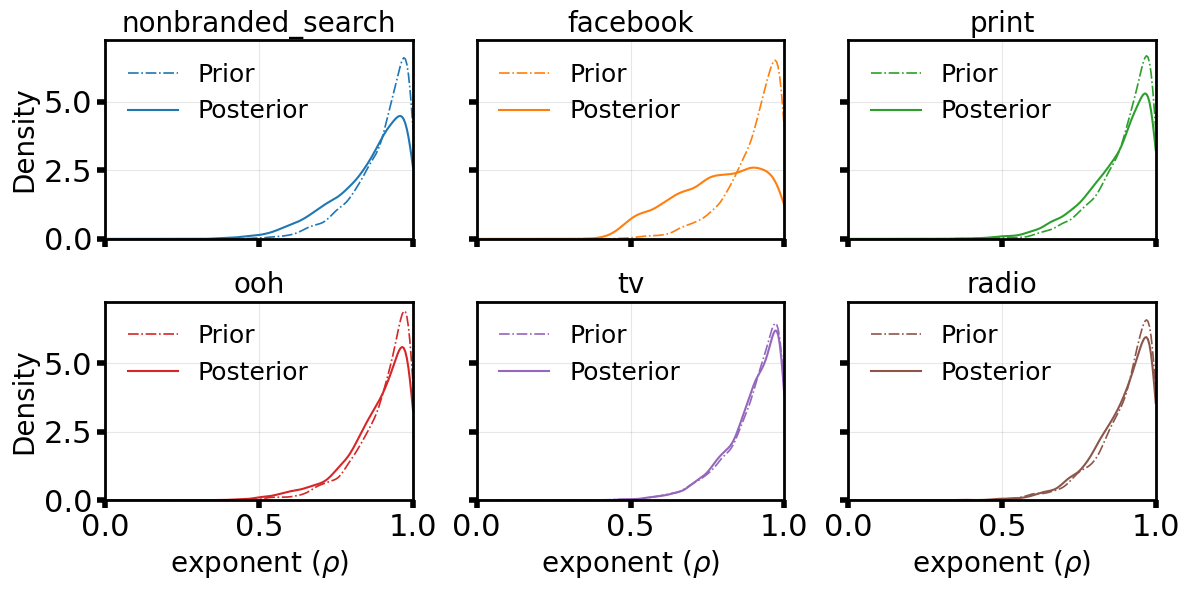

In [38]:
def plot_exponent_prior_posterior(
    mmm,
    channel_names,
    n_prior_samples=4000,
    n_grid=200,
    seed=0,
):
    """
    Plot prior & posterior densities for exponent per channel, 
    the default prior used: exponent ~ Beta(9, 1) on [0, 1].
    """

    # Posterior from trace
    exp_post = np.asarray(mmm.trace["exponent"])
    if exp_post.ndim == 3:
        exp_post = exp_post[:, :, 0]

    n_post_samples, n_channels_post = exp_post.shape
    n_channels = len(channel_names)

    # Prior: Beta(9, 1) for each channel
    key = random.PRNGKey(seed)
    # vectorised Beta over channels
    exp_prior_dist = dist.Beta(
        concentration1=jnp.full((n_channels,), 9.0),
        concentration0=jnp.full((n_channels,), 1.0),
    )
    # (n_prior_samples, n_channels)
    prior_samples_all = np.asarray(
        exp_prior_dist.sample(key, sample_shape=(n_prior_samples,))
    )

    # First pass: compute densities & global max
    x = np.linspace(0.0, 1.0, n_grid)
    per_channel_results = []  # list of (prior_density, post_density)
    global_max = 0.0

    for i in range(n_channels):
        prior_samples = prior_samples_all[:, i]
        post_samples = exp_post[:, i]

        prior_density = _gaussian_kde_1d(prior_samples, x)
        post_density = _gaussian_kde_1d(post_samples, x)

        per_channel_results.append((prior_density, post_density))
        global_max = max(global_max, prior_density.max(), post_density.max())

    # Create subplots with shared axes
    n_cols = 3
    n_rows = int(np.ceil(n_channels / n_cols))
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 3 * n_rows),
        sharex=True,
        sharey=True,
    )
    axes = np.array(axes).reshape(-1)

    for i, ch_name in enumerate(channel_names):
        ax = axes[i]
        color = media_colors.get(ch_name, "#333333")

        prior_density, post_density = per_channel_results[i]

        ax.plot(
            x,
            prior_density,
            linestyle="-.",
            color=color,
            linewidth=1.2,
            label="Prior",
        )
        ax.plot(
            x,
            post_density,
            linestyle="-",
            color=color,
            linewidth=1.5,
            label="Posterior",
        )

        ax.set_title(ch_name, fontsize=20)
        ax.set_xlim(0.0, 1.0)
        ax.set_ylim(0, global_max * 1.05)

        if i % n_cols == 0:
            ax.set_ylabel("Density", fontsize=20)
        if i >= (n_rows - 1) * n_cols:
            ax.set_xlabel(r"exponent ($\rho$)", fontsize=20)

        ax.grid(True, alpha=0.3)

        
    for ax in axes:
        if not ax.has_data():
            continue
        ax.tick_params(axis="both", which="both",
                       width=4, length=6, labelsize=22)
        for spine in ["bottom", "left", "top", "right"]:
            ax.spines[spine].set_linewidth(2)

    # One legend
    
    axes[0].legend(loc="upper left", frameon=False, fontsize=18)
    axes[1].legend(loc="upper left", frameon=False, fontsize=18)
    axes[2].legend(loc="upper left", frameon=False, fontsize=18)
    axes[3].legend(loc="upper left", frameon=False, fontsize=18)
    axes[4].legend(loc="upper left", frameon=False, fontsize=18)
    axes[5].legend(loc="upper left", frameon=False, fontsize=18)
    fig.tight_layout()
    return fig



fig = plot_exponent_prior_posterior(
    mmm,
    channel_names=mdsp_cols,
    n_prior_samples=4000,
    seed=123,
)
plt.show()
fig.savefig("phi_prior_poterior.jpeg", format='jpeg', dpi=300, bbox_inches='tight')

## Contribution Analysis

In [39]:
# Adding same date range as original data to cont dataset
date_range = pd.date_range(start="2017-07-23", end="2021-07-17", freq='W')
cont["Week"] = date_range
cont

,nonbranded_search_percentage,facebook_percentage,print_percentage,ooh_percentage,tv_percentage,radio_percentage,baseline_percentage,avg_prediction,nonbranded_search contribution,facebook contribution,print contribution,ooh contribution,tv contribution,radio contribution,baseline contribution,period,Week
0,0.181301,0.290132,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.528567,52281.695312,9478.724609,15168.602539,0.000000,0.000000e+00,0.000000e+00,0.000000,27634.367188,1,2017-07-23
1,0.194766,0.321275,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.483959,56692.933594,11041.874023,18214.027344,0.000000,0.000000e+00,0.000000e+00,0.000000,27437.033203,2,2017-07-30
2,0.203064,0.319890,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.477046,57084.800781,11591.847656,18260.857422,0.000000,0.000000e+00,0.000000e+00,0.000000,27232.093750,3,2017-08-06
3,0.203713,0.321376,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.474910,56907.894531,11592.890625,18288.857422,0.000000,0.000000e+00,0.000000e+00,0.000000,27026.148438,4,2017-08-13
4,0.199311,0.334491,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.466199,57518.371094,11464.039062,19239.349609,0.000000,0.000000e+00,0.000000e+00,0.000000,26814.984375,5,2017-08-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.128620,0.295010,1.615715e-06,7.323319e-27,3.492890e-14,0.000051,0.576318,71029.148438,9135.757812,20954.279297,0.114763,5.201691e-22,2.480970e-09,3.609094,40935.390625,204,2021-06-13
204,0.130486,0.293129,1.169808e-06,4.833391e-27,2.566470e-14,0.000027,0.576357,71102.929688,9277.922852,20842.339844,0.083177,3.436683e-22,1.824835e-09,1.893242,40980.691406,205,2021-06-20
205,0.130463,0.288011,8.737871e-07,3.225413e-27,1.906557e-14,0.000014,0.581511,70411.492188,9186.108398,20279.265625,0.061525,2.271062e-22,1.342435e-09,1.016091,40945.039062,206,2021-06-27
206,0.130523,0.288069,6.587895e-07,2.136395e-27,1.405715e-14,0.000008,0.581399,70263.671875,9171.059570,20240.773438,0.046289,1.501109e-22,9.877069e-10,0.556604,40851.234375,207,2021-07-04


### Baseline and Marketing Channels Contribution

In [40]:
cont['total_marketing_contribution'] = (
    cont['nonbranded_search contribution'] +
    cont['facebook contribution'] +
    cont['print contribution'] +
    cont['ooh contribution'] +
    cont['tv contribution'] +
    cont['radio contribution']
)


cont_channel_level = []


for channel in mdsp_cols:
    contribution_percentage = (
        sum(cont[f'{channel} contribution']) / sum(cont['total_marketing_contribution'])
    ) * 100

    cont_channel_level.append((channel, contribution_percentage))

cont_channel_level = pd.DataFrame(cont_channel_level, columns=['Channel', 'Contribution Percentage'])
cont_channel_level

,Channel,Contribution Percentage
0,nonbranded_search,23.649967
1,facebook,58.196500
2,print,2.024309
3,ooh,0.213704
4,tv,5.237140
5,radio,10.678381


In [41]:
# Calculating total Basline contribution on sales
baseline_cont = (cont['baseline contribution'].sum() / cont.avg_prediction.sum())*100
print(f'BaseLine Contribution is {round(baseline_cont, 2)} %')

BaseLine Contribution is 40.99 %


In [42]:
# Calculating total Marketing contribution on sales
marketing_cont = (cont['total_marketing_contribution'].sum() / cont.avg_prediction.sum())*100
print(f'Marketing Contribution is {round(marketing_cont, 2)} %')

Marketing Contribution is 59.01 %


/tmp/ipykernel_21903/377444597.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


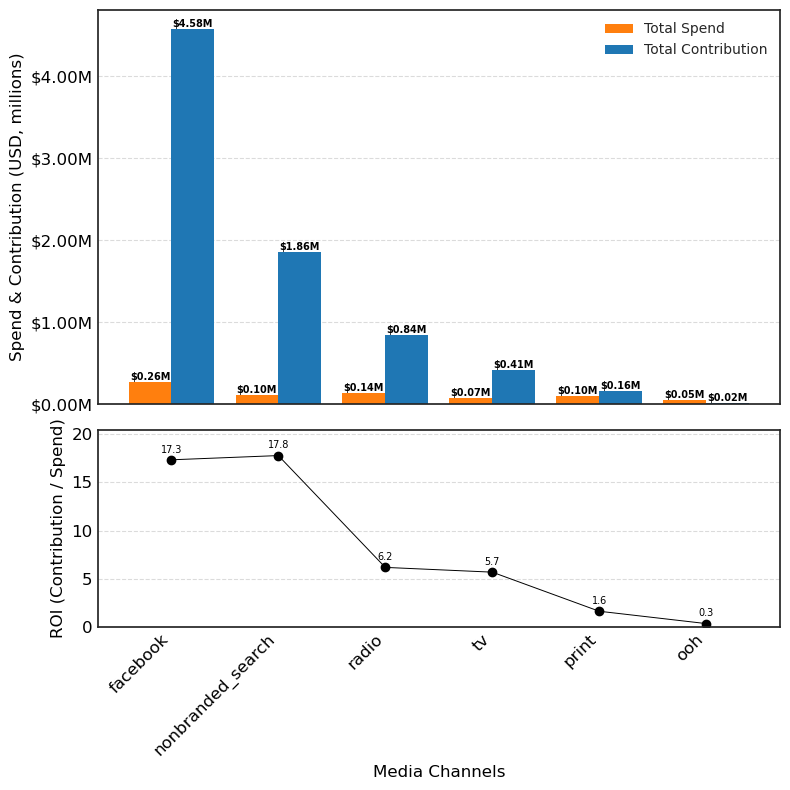

In [43]:
# Media spends vs media contribution plot + ROI figures plot

plt.style.use("seaborn-white")
contribution_columns = [
    'nonbranded_search contribution',
    'facebook contribution',
    'print contribution',
    'ooh contribution',
    'tv contribution',
    'radio contribution',
]

# Aggregate total spend and contributions
total_spend = df[mdsp_cols].sum().values
total_contribution = cont[contribution_columns].sum().values

df = pd.DataFrame({
    "Media": mdsp_cols,
    "Spend": total_spend,
    "Contribution": total_contribution,
})

# Sort by Contribution in descending order
df = df.sort_values(by="Contribution", ascending=False).reset_index(drop=True)

custom_colors = ["#ff7f0e", "#1f77b4"]  # orange spend, blue contribution

def format_millions(value):
    return f"${value / 1_000_000:.2f}M"

def millions_formatter(y, _):
    return format_millions(y)

# ROI per channel
roi = df["Contribution"] / df["Spend"].replace(0, np.nan)

# Two vertically stacked subplots that share x-axis
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(8, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1.5]},
)

width = 0.4
x = np.arange(len(df))

# Spend vs Contribution
bars1 = ax1.bar(
    x - width / 2,
    df["Spend"],
    width=width,
    color=custom_colors[0],
    label="Total Spend",
)
bars2 = ax1.bar(
    x + width / 2,
    df["Contribution"],
    width=width,
    color=custom_colors[1],
    label="Total Contribution",
)

label_fontsize = 7

for bar in bars1:
    h = bar.get_height()
    if h > 0:
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            h,
            format_millions(h),
            ha="center",
            va="bottom",
            fontsize=label_fontsize,
            fontweight="bold",
            color="black",
        )

for bar in bars2:
    h = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        h,
        format_millions(h),
        ha="center",
        va="bottom",
        fontsize=label_fontsize,
        fontweight="bold",
        color="black",
    )

ax1.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax1.tick_params(axis="y", labelsize=12, colors="black")
ax1.set_ylabel("Spend & Contribution (USD, millions)", fontsize=12, color="black")
ax1.grid(axis="y", linestyle="--", alpha=0.7)
ax1.legend(fontsize=10, loc="upper right", frameon=False)
ax1.tick_params(axis="x", labelbottom=False)

# ROI line
ax2.plot(
    x,
    roi,
    color="black",
    marker="o",
    linestyle="-",
    linewidth=0.7,
)

offset = 0.03 * roi.max() 

for xi, r in zip(x, roi):
    ax2.text(
        xi,
        r + offset,
        f"{r:.1f}",
        ha="center",
        va="bottom",
        fontsize=7,
        color="black",
    )

ax2.set_ylim(0, roi.max() * 1.15)
ax2.set_ylabel("ROI (Contribution / Spend)", fontsize=12, color="black")
ax2.tick_params(axis="y", labelsize=12, colors="black")

def roi_formatter(y, _):
    return f"{y:.0f}"
ax2.yaxis.set_major_formatter(FuncFormatter(roi_formatter))

ax2.set_xticks(x)
ax2.set_xticklabels(df["Media"], rotation=45, ha="right", fontsize=12, color="black")
ax2.set_xlabel("Media Channels", fontsize=12, color="black")
ax2.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("Media_Contribution_and_ROI.jpeg",
            format="jpeg", dpi=300, bbox_inches="tight")
plt.show()

### Contribution of Seasonality

In [44]:
np.mean(mmm.trace['gamma_seasonality'], axis=0)

Array([[-0.01255026,  0.14557114],
       [-0.00893883, -0.03414898]], dtype=float32)

In [45]:
# Seasonality_effect 
gamma_seasonality = np.array(np.mean(mmm.trace['gamma_seasonality'], axis=0))
seasonality_component = calculate_seasonality(
    number_periods=len(cont), 
    degrees=mmm._degrees_seasonality , 
    gamma_seasonality=gamma_seasonality, 
    frequency=mmm._seasonality_frequency
)
seasonality_effect = target_scaler.inverse_transform(seasonality_component)
seasonality_effect

Array([  7142.442  ,   6903.914  ,   6663.21   ,   6421.3145 ,
         6173.6562 ,   5910.6367 ,   5618.544  ,   5280.7695 ,
         4879.2666 ,   4396.144  ,   3815.3098 ,   3124.0496 ,
         2314.4456 ,   1384.5317 ,    339.13058,   -809.7134 ,
        -2042.7249 ,  -3333.8228 ,  -4650.9673 ,  -5957.4106 ,
        -7213.2314 ,  -8377.143  ,  -9408.429  , -10268.909  ,
       -10924.859  , -11348.711  , -11520.513  , -11429.022  ,
       -11072.372  , -10458.289  ,  -9603.826  ,  -8534.652  ,
        -7283.908  ,  -5890.6978 ,  -4398.311  ,  -2852.255  ,
        -1298.2192 ,    219.96385,   1662.1498 ,   2993.539  ,
         4185.978  ,   5218.8774 ,   6079.7    ,   6763.992  ,
         7274.987  ,   7622.778  ,   7823.161  ,   7896.1895 ,
         7864.542  ,   7751.817  ,   7580.844  ,   7372.114  ,
         7142.442  ,   6903.915  ,   6663.2085 ,   6421.314  ,
         6173.656  ,   5910.6367 ,   5618.544  ,   5280.77   ,
         4879.266  ,   4396.1436 ,   3815.309  ,   3124

In [46]:
seasonality_effect_df = pd.DataFrame({
    'Week': date_range,
    'seasonality_effect': seasonality_effect
})
seasonality_effect_df

,Week,seasonality_effect
0,2017-07-23,7142.441895
1,2017-07-30,6903.914062
2,2017-08-06,6663.209961
3,2017-08-13,6421.314453
4,2017-08-20,6173.656250
...,...,...
203,2021-06-13,7896.188965
204,2021-06-20,7864.541016
205,2021-06-27,7751.816895
206,2021-07-04,7580.843262


### Contribution of trend

In [47]:
trend = mmm.trace[_COEF_TREND].reshape(1, -1) * np.arange(len(cont)).reshape(-1, 1) ** mmm.trace[_EXPO_TREND]
trend_decomp = np.mean(trend, axis=1)
trend_decomp_target = target_scaler.inverse_transform(trend_decomp)
trend_decomp_target.shape

(208,)

In [48]:
trend_decomp_target

Array([    0.      ,    41.19429 ,    76.96128 ,   112.909386,
         149.40118 ,   186.51471 ,   224.25899 ,   262.62152 ,
         301.5824  ,   341.12006 ,   381.21295 ,   421.84064 ,
         462.98398 ,   504.625   ,   546.74713 ,   589.33527 ,
         632.37494 ,   675.8529  ,   719.7569  ,   764.0755  ,
         808.79785 ,   853.91394 ,   899.4145  ,   945.29034 ,
         991.53314 ,  1038.135   ,  1085.0884  ,  1132.3864  ,
        1180.0219  ,  1227.9889  ,  1276.281   ,  1324.8926  ,
        1373.8179  ,  1423.0516  ,  1472.5889  ,  1522.4248  ,
        1572.5543  ,  1622.9733  ,  1673.6774  ,  1724.6622  ,
        1775.9242  ,  1827.4591  ,  1879.2633  ,  1931.3334  ,
        1983.6656  ,  2036.257   ,  2089.104   ,  2142.2036  ,
        2195.5527  ,  2249.1484  ,  2302.9878  ,  2357.0684  ,
        2411.387   ,  2465.9417  ,  2520.7295  ,  2575.7476  ,
        2630.9941  ,  2686.4668  ,  2742.163   ,  2798.0808  ,
        2854.2178  ,  2910.5718  ,  2967.141   ,  3023.

In [49]:
(trend_decomp_target.sum() / cont.avg_prediction.sum()) * 100

Array(9.025593, dtype=float32)

In [50]:
trend_effect_df = pd.DataFrame({
    'Week': date_range,
    'trend_effect': trend_decomp_target
})

trend_effect_df

,Week,trend_effect
0,2017-07-23,0.000000
1,2017-07-30,41.194290
2,2017-08-06,76.961281
3,2017-08-13,112.909386
4,2017-08-20,149.401184
...,...,...
203,2021-06-13,12547.269531
204,2021-06-20,12624.229492
205,2021-06-27,12701.294922
206,2021-07-04,12778.465820


## Contribution of intercept

In [51]:
intercept_target = target_scaler.inverse_transform(jnp.mean(mmm.trace['intercept']))
intercept_target

Array(20491.924, dtype=float32)

In [52]:
intercept_target * len(cont) / temp.sales.sum()

Array(0.24070074, dtype=float32)

In [53]:
num_days = len(cont)
intercept_effects = np.tile(intercept_target, num_days)[:num_days]

intercept_effect_df = pd.DataFrame({
    'Week': date_range,
    'intercept_effect': intercept_effects
})
intercept_effect_df

,Week,intercept_effect
0,2017-07-23,20491.923828
1,2017-07-30,20491.923828
2,2017-08-06,20491.923828
3,2017-08-13,20491.923828
4,2017-08-20,20491.923828
...,...,...
203,2021-06-13,20491.923828
204,2021-06-20,20491.923828
205,2021-06-27,20491.923828
206,2021-07-04,20491.923828


### Baseline Decomposition 

In [54]:
baseline_decomps_list = [intercept_effect_df, trend_effect_df, seasonality_effect_df]
baseline_decomps = reduce(lambda left, right: pd.merge(left, right, on='Week', how='left'), baseline_decomps_list)
baseline_decomps['baseline_estimate'] = baseline_decomps.drop(columns=['Week']).sum(axis=1)
baseline_decomps['Week'] = date_range
baseline_decomps['Week'] = pd.to_datetime(baseline_decomps['Week'], errors='coerce')
baseline_decomps

,Week,intercept_effect,trend_effect,seasonality_effect,baseline_estimate
0,2017-07-23,20491.923828,0.000000,7142.441895,27634.365234
1,2017-07-30,20491.923828,41.194290,6903.914062,27437.031250
2,2017-08-06,20491.923828,76.961281,6663.209961,27232.093750
3,2017-08-13,20491.923828,112.909386,6421.314453,27026.148438
4,2017-08-20,20491.923828,149.401184,6173.656250,26814.980469
...,...,...,...,...,...
203,2021-06-13,20491.923828,12547.269531,7896.188965,40935.382812
204,2021-06-20,20491.923828,12624.229492,7864.541016,40980.695312
205,2021-06-27,20491.923828,12701.294922,7751.816895,40945.035156
206,2021-07-04,20491.923828,12778.465820,7580.843262,40851.234375


In [55]:
# Error between estimated baseline and and baseline cont from the model
(cont['baseline contribution'] - baseline_decomps['baseline_estimate']).describe()

count    208.000000
mean       0.002657
std        0.006809
min       -0.017578
25%        0.000000
50%        0.001953
75%        0.003906
max        0.031250
dtype: float64

In [56]:
baseline_decomps

,Week,intercept_effect,trend_effect,seasonality_effect,baseline_estimate
0,2017-07-23,20491.923828,0.000000,7142.441895,27634.365234
1,2017-07-30,20491.923828,41.194290,6903.914062,27437.031250
2,2017-08-06,20491.923828,76.961281,6663.209961,27232.093750
3,2017-08-13,20491.923828,112.909386,6421.314453,27026.148438
4,2017-08-20,20491.923828,149.401184,6173.656250,26814.980469
...,...,...,...,...,...
203,2021-06-13,20491.923828,12547.269531,7896.188965,40935.382812
204,2021-06-20,20491.923828,12624.229492,7864.541016,40980.695312
205,2021-06-27,20491.923828,12701.294922,7751.816895,40945.035156
206,2021-07-04,20491.923828,12778.465820,7580.843262,40851.234375


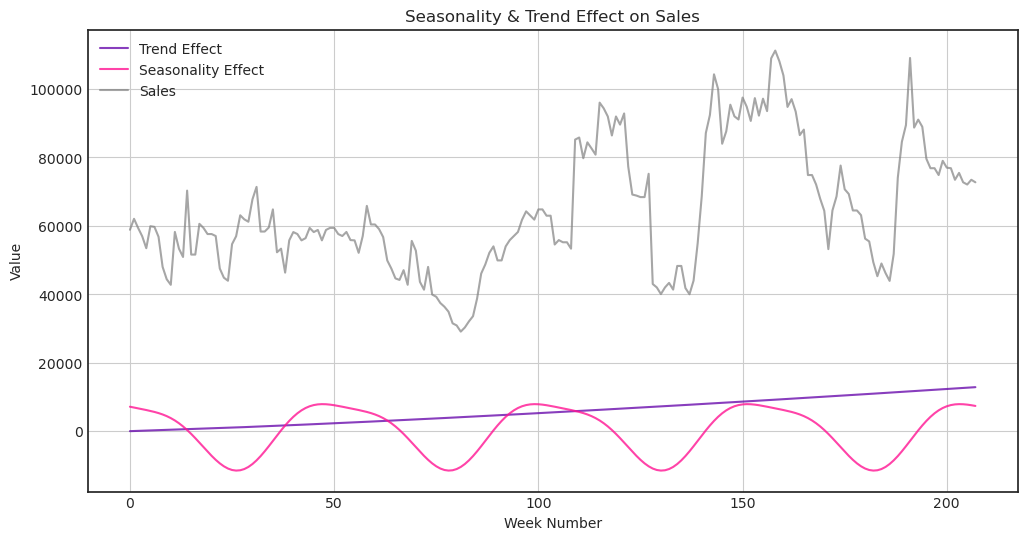

In [57]:
# Sales decomposition plot by trend, and seasonality
merged_df = pd.merge(
    baseline_decomps,
    temp[['Week', 'sales']],
    on='Week',
    how='left'
)


merged_df['Week_Num'] = range(len(merged_df))

plt.figure(figsize=(12, 6))

# Trend in strong purple
plt.plot(
    merged_df['Week_Num'],
    merged_df['trend_effect'],
    label="Trend Effect",
    alpha=0.8,
    color="#6a0dad"   
)

# Seasonality in bright pink
plt.plot(
    merged_df['Week_Num'],
    merged_df['seasonality_effect'],
    label="Seasonality Effect",
    alpha=0.8,
    color="#ff1493"   
)

# Sales in grey
plt.plot(
    merged_df['Week_Num'],
    merged_df['sales'],
    label="Sales",
    alpha=0.7,
    linestyle="solid",
    color="grey"
)

plt.title("Seasonality & Trend Effect on Sales")
plt.xlabel("Week Number")
plt.ylabel("Value")
plt.legend(loc="upper left")
plt.xticks(rotation=0)
plt.grid(True)

plt.savefig(
    "Sales_Trend_Seasonality.jpeg",
    format='jpeg',
    dpi=300,
    bbox_inches='tight'
)
plt.show()



## plotting residuals of the model

In [58]:
# Ensure date column is in datetime format
temp['Week'] = pd.to_datetime(temp['Week'], errors='coerce')
cont['Week'] = pd.to_datetime(cont['Week'], errors='coerce')

# Merge temp and cont on date to align data
merged_df = pd.merge(temp, cont[['Week', 'avg_prediction']], on='Week', how='left')

# Calculate the difference
merged_df['sales_difference'] = merged_df['sales'] - merged_df['avg_prediction']
merged_df

,Week,sales,branded_search,nonbranded_search,facebook,print,ooh,tv,radio,avg_prediction,sales_difference
0,2017-07-23,58850.0000,1528.80,463.3200,802.6200,0,0,0,0,52281.695312,6568.304688
1,2017-07-30,62050.0000,1575.60,468.0000,819.3120,0,0,0,0,56692.933594,5357.066406
2,2017-08-06,59388.0000,1544.40,477.3600,749.0340,0,0,0,0,57084.800781,2303.199219
3,2017-08-13,56964.0000,1528.80,468.0000,741.4680,0,0,0,0,56907.894531,56.105469
4,2017-08-20,53460.0000,1560.00,458.6400,811.2000,0,0,0,0,57518.371094,-4058.371094
...,...,...,...,...,...,...,...,...,...,...,...
255,2022-06-12,98173.4880,3466.32,814.9285,1715.8284,1000,0,2500,0,NaN,NaN
256,2022-06-19,104221.7248,3534.96,829.0855,1802.8296,0,0,2500,0,NaN,NaN
257,2022-06-26,103283.6800,3363.36,793.6930,1631.2296,0,0,2500,0,NaN,NaN
258,2022-07-03,105279.5200,3534.96,829.0855,1855.8540,0,0,2500,0,NaN,NaN


In [59]:
merged_df['sales_difference'].describe()

count      208.000000
mean        -8.121715
std       8923.046019
min     -22758.148125
25%      -5914.952930
50%        156.519531
75%       5479.913945
max      26583.225937
Name: sales_difference, dtype: float64

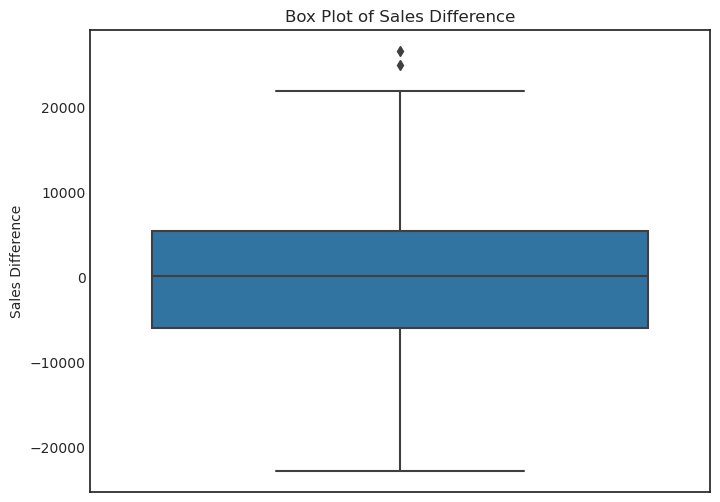

In [60]:
# boxplot to inspect the distribution of residuals (sales - predicted sales)
plt.figure(figsize=(8, 6))
sns.boxplot(y=merged_df['sales_difference'])

plt.ylabel('Sales Difference')
plt.title('Box Plot of Sales Difference')

plt.show()

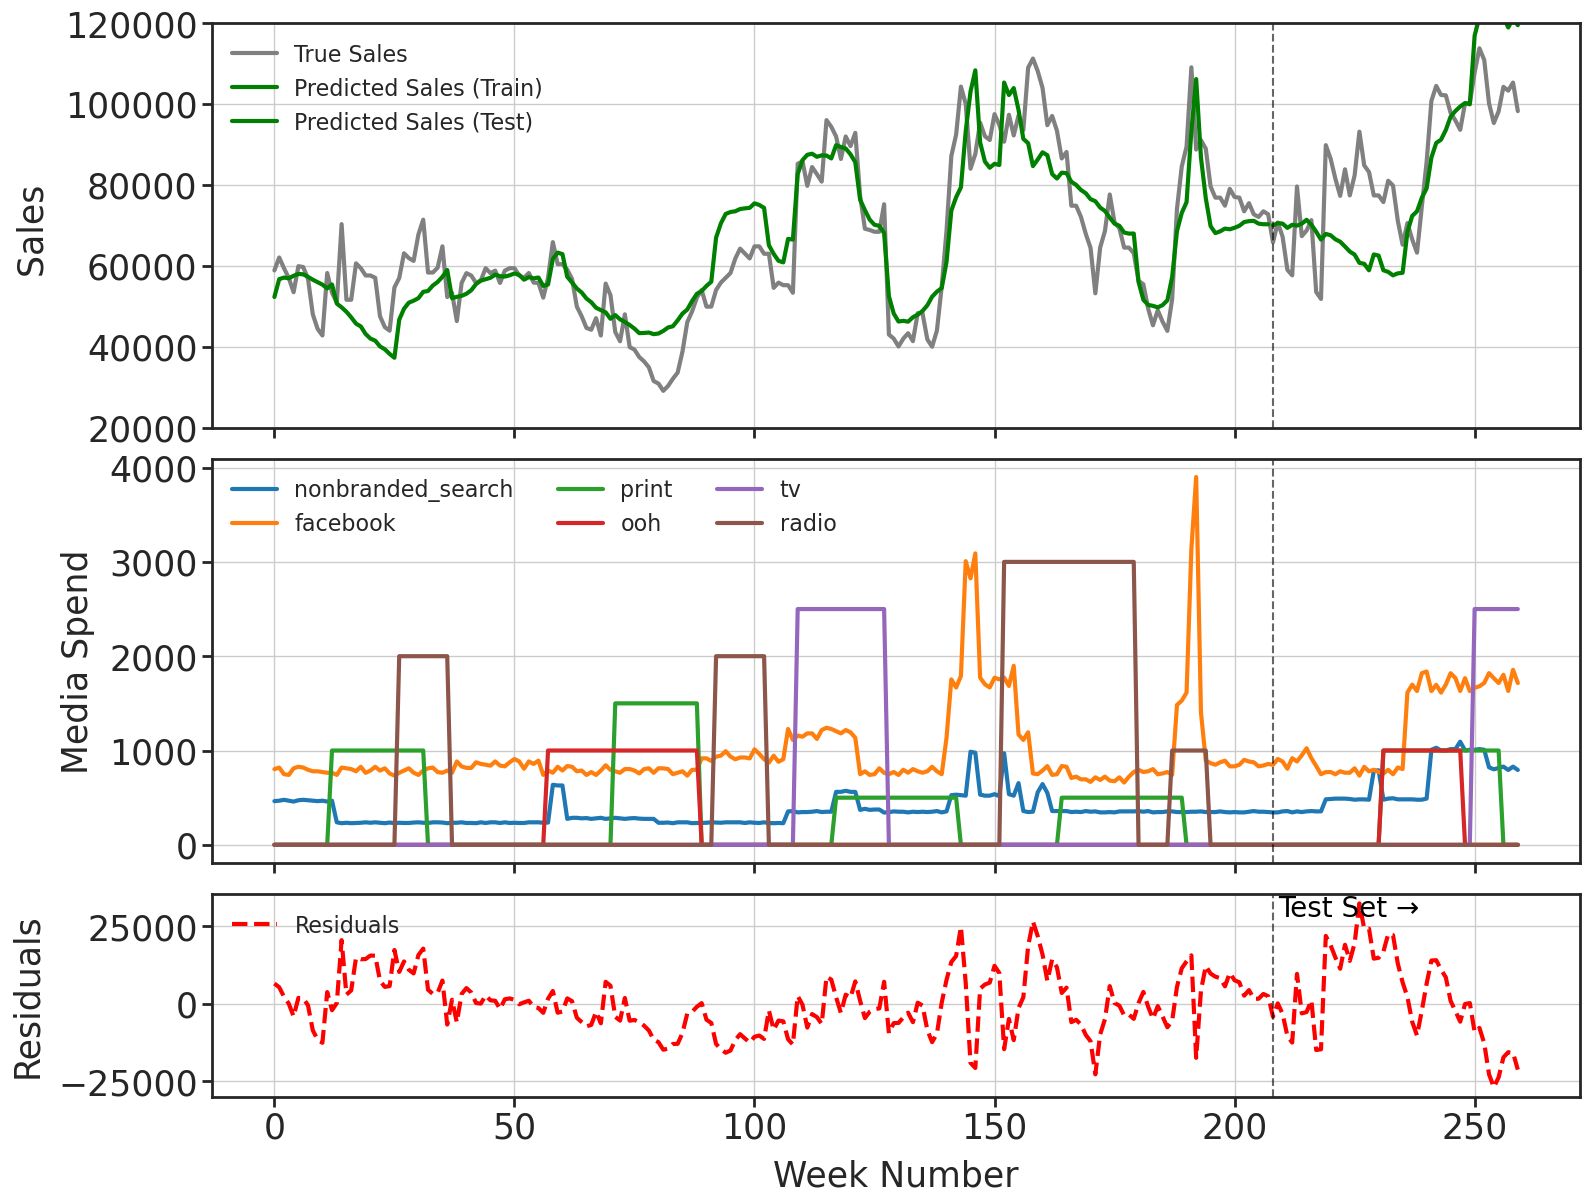

In [61]:
# Media spends + True and predicted Sales + Residuals in one plot

#  Take mean over samples of test set predictions
new_predictions_mean = np.asarray(new_predictions).mean(axis=0)

# Convert predictions back to original sales scale
new_predictions = target_scaler.inverse_transform(
    new_predictions_mean.reshape(-1, 1)
).ravel()

n_test = media_data_test.shape[0]


# Write test predictions into the correct rows of merged_df
merged_df.loc[split_point:split_point + n_test - 1, 'avg_prediction'] = new_predictions

# Recompute residuals over the full period (train + test)
merged_df['sales_difference'] = merged_df['sales'] - merged_df['avg_prediction']

# Build the combined (train + test) 3-panel plot

merged_df['Week_Num'] = range(len(merged_df))

# Setup 3 stacked subplots
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(16, 12),                
    sharex=True,
    gridspec_kw={'height_ratios': [2, 2, 1]}
)

# Sales & Predictions
ax1.plot(
    merged_df['Week_Num'],
    merged_df['sales'],
    label='True Sales',
    color='grey',
    linewidth=3                     
)

# Train/test masks based on split_point
train_mask = merged_df['Week_Num'] < split_point
test_mask = ~train_mask

# Plot train predictions
ax1.plot(
    merged_df.loc[train_mask, 'Week_Num'],
    merged_df.loc[train_mask, 'avg_prediction'],
    label='Predicted Sales (Train)',
    color='green',
    linewidth=3
)

# Plot test predictions we just added
ax1.plot(
    merged_df.loc[test_mask, 'Week_Num'],
    merged_df.loc[test_mask, 'avg_prediction'],
    label='Predicted Sales (Test)',
    color='green',
    linewidth=3
)

ax1.set_ylabel("Sales ", fontsize=25, labelpad=10)
ax1.legend(loc='upper left', fontsize=16)
ax1.grid(True, linewidth=1)
ax1.set_ylim(20000, 120000)


for media in mdsp_cols:
    ax2.plot(
        merged_df['Week_Num'],
        merged_df[media],
        label=media,
        color=media_colors.get(media, None),
        linewidth=3                        
    )

ax2.set_ylabel("Media Spend", fontsize=25, labelpad=10)
ax2.legend(loc='upper left', ncol=3, fontsize=16)
ax2.grid(True, linewidth=1)

# Residuals
ax3.plot(
    merged_df['Week_Num'],
    merged_df['sales_difference'],
    label='Residuals',
    linestyle='--',
    color='red',
    linewidth=3                          
)
ax3.set_xlabel("Week Number", fontsize=25, labelpad=10)
ax3.set_ylabel("Residuals", fontsize=25, labelpad=10)
ax3.legend(loc='upper left', fontsize=16)
ax3.grid(True, linewidth=1)

# Add vertical line to mark train/test split
for ax in (ax1, ax2, ax3):
    ax.axvline(x=split_point, color='black', linestyle='--', alpha=0.6)

# Add text on residuals panel
ax3.text(
    split_point + 1,
    ax3.get_ylim()[1] * 0.8,
    'Test Set →',
    color='black',
    fontsize=20
)

# Global axis styling
for ax in (ax1, ax2, ax3):
    ax.tick_params(axis='both', which='both', width=2, length=7, labelsize=25)
    for spine in ['bottom', 'left', 'top', 'right']:
        ax.spines[spine].set_linewidth(2)

plt.tight_layout()
plt.savefig(
    "Sales_Predictions_Media_Residuals.jpeg",
    format='jpeg',
    dpi=300,
    bbox_inches='tight'
)
plt.show()


## Budget Optimization

In [62]:
# Price per media unit for each channel.
# If media_data is already in spend units, prices are just 1s.
prices = jnp.ones(mmm.n_media_channels)
prices

Array([1., 1., 1., 1., 1., 1.], dtype=float32)

In [63]:
# Number of future periods in this case weeks we want to optimize over.
n_time_periods = 20

# Set total budget for the optimization horizon. In this code: average historic spend per week * number of future weeks.
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods
budget

Array(55699.082, dtype=float32)

In [64]:
# Run budget optimization given the fitted MMM
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1607290.7242960022
            Iterations: 21
            Function evaluations: 261
            Gradient evaluations: 20


In [65]:
# Convert the optimized solution into budgets per channel
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([ 8262.433 , 23050.348 ,  5615.385 ,  2461.5383,  5480.7705,
       10828.608 ], dtype=float32)

In [66]:
# Historic / pre-optimization budget allocation (used as baseline)
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([ 7123.8564, 19873.97  ,  7262.363 ,  3183.5015,  4725.5107,
       13529.882 ], dtype=float32)

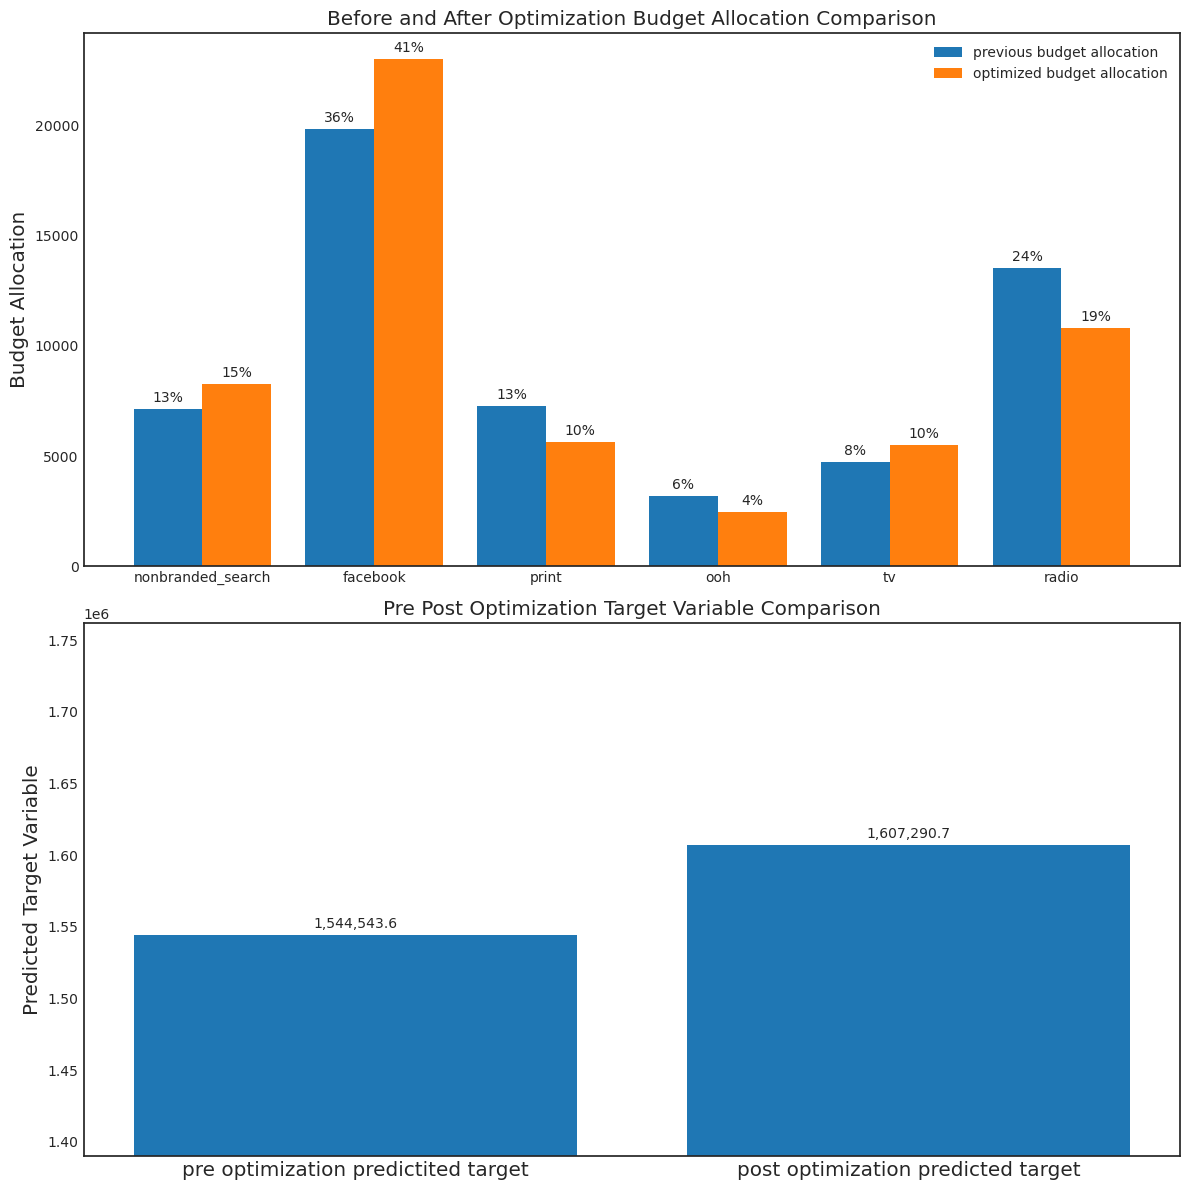

In [67]:
# Plot pre vs post optimization budget
# Compares:
# - channel-level budgets before vs after optimization
# - predicted sales before vs after optimization
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(12,12))

In [68]:
# Save the plot
fig = plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(12,12))

fig.savefig("Budget_optimization.jpeg", format='jpeg', dpi=300, bbox_inches='tight')